# Bayesian SVAR analysis for macroeconomic and IRRBB forecasting with Python

## Introduction

This notebook demonstrates a full pipeline that links Bayesian SVAR modeling to Basel III interest rate risk in the banking book (IRRBB) metrics. The goal is to translate yield-curve and macroeconomic scenarios into consistent forecasts of bank-level Net Interest Income (NII) and Economic Value of Equity (EVE) responses.

The analysis proceeds in three layers:

Bayesian VAR estimation – building a reduced-form model for key macro and yield-curve factors.

Conditional forecasts – imposing Basel III and structural macro scenarios as exogenous paths and generating consistent projections.

IRRBB mapping – translating yield-curve shifts into simplified but realistic NII and EVE sensitivities calibrated to supervisory magnitudes.

In [1]:
import requests, io
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import pymc as pm
import pytensor
import pytensor.tensor as pt
import arviz as az

## 1) ETL

This section documents how the macro–financial panel used in the BVAR is built. The objective is to end up with a single, quarterly, balanced dataset containing the variables that will later enter the VAR and the conditional forecasts.

All of the data is imported from the European Central Bank ECB Statistical Data Warehouse

We work with two broad blocks of variables:

### Yield-curve block

Spot rates - Government bond, nominal, all issuers whose rating is triple A - Euro area (changing composition), Euro area

We have 3 maturities: 1y, 5y and 10y. From those, we apply simple formulas to estimate Nelson-Siegel-like factors: level (the average across the 3 maturities), slope (10y - 1y) and curvature (2 * 5y - 1y - 10y) 

### Macroeconomic block

gdp_q_ann – real GDP growth at market prices, Euro area 20, quarterly frequency, annualized.

infl_q_ann – Euro area HICP inflation at quarterly frequency, annualized.

gg_deficit_pct_gdp - Government deficit(-) or surplus(+) (as % of GDP), Euro area 20, Quarterly 

gg_debt_pct_gdp - Government debt (consolidated) (as % of GDP), Euro area 20, Quarterly 

policy_rate - Level of rate of main refinancing operations - fixed rate tenders (fixed rate) (date of changes), Euro area

We winsorize the GDP series at 15/-15 during the COVID shock

These are the variables referenced later in the notebook in var_order, so we keep the names consistent between ETL and modeling.

In [2]:
from src import etl

OK  https://data-api.ecb.europa.eu/service/data/ICP/M.U2.N.000000.4.INX?startPeriod=2000-01&format=csvdata
OK  https://data-api.ecb.europa.eu/service/data/MNA/Q.Y.I9.W2.S1.S1.B.B1GQ._Z._Z._Z.EUR.LR.N?startPeriod=2000-01&format=csvdata
OK  https://data-api.ecb.europa.eu/service/data/FM/B.U2.EUR.4F.KR.MRR_FR.LEV?startPeriod=2000-01&format=csvdata
OK  https://data-api.ecb.europa.eu/service/data/GFS/Q.N.I9.W0.S13.S1._Z.B.B9._Z._Z._Z.XDC_R_B1GQ_CY._Z.S.V.CY._T?startPeriod=2000-01&format=csvdata
OK  https://data-api.ecb.europa.eu/service/data/GFS/Q.N.I9.W0.S13.S1.C.L.LE.GD.T._Z.XDC_R_B1GQ_CY._T.F.V.N._T?startPeriod=2000-01&format=csvdata
OK  https://data-api.ecb.europa.eu/service/data/YC/B.U2.EUR.4F.G_N_A.SV_C_YM.SR_1Y?startPeriod=2000-01&format=csvdata
OK  https://data-api.ecb.europa.eu/service/data/YC/B.U2.EUR.4F.G_N_A.SV_C_YM.SR_5Y?startPeriod=2000-01&format=csvdata
OK  https://data-api.ecb.europa.eu/service/data/YC/B.U2.EUR.4F.G_N_A.SV_C_YM.SR_10Y?startPeriod=2000-01&format=csvdata
Saved

Our sample period starts at 2004 Q3 and ends at 2025 Q2

In [3]:
panel = pd.read_csv("data/quarterly_panel_modelvars.csv", parse_dates=["date"], index_col="date")
panel

,infl_q_ann,gdp_q_ann,policy_rate,gg_deficit_pct_gdp,gg_debt_pct_gdp,yc_spot_1y,yc_spot_5y,yc_spot_10y,level,slope_10y_1y,curvature_ns_like
date,,,,,,,,,,,
2004-09-30,0.369011,0.901423,4.25,-2.997,71.161,2.291667,3.372940,4.104690,3.256432,1.813023,0.349523
2004-12-31,2.462038,1.774910,4.25,-2.897,69.721,2.205564,3.102433,3.849834,3.052610,1.644269,0.149469
2005-03-31,0.350486,1.065693,4.25,-2.885,71.059,2.213501,3.024397,3.635017,2.957638,1.421516,0.200277
2005-06-30,4.843364,2.474232,4.25,-2.917,71.692,2.067228,2.742555,3.392596,2.734126,1.325368,0.025285
2005-09-30,1.460457,2.972809,4.25,-2.711,71.186,2.084327,2.645390,3.219840,2.649852,1.135513,-0.013388
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-30,6.009073,0.900181,4.25,-3.436,87.685,3.258067,2.487573,2.557599,2.767746,-0.700468,-0.840519
2024-09-30,0.980509,1.618255,3.65,-3.247,87.709,2.834863,2.180941,2.377072,2.464292,-0.457790,-0.850053
2024-12-31,0.904573,1.708808,3.15,-3.064,87.080,2.326712,2.058374,2.354717,2.246601,0.028006,-0.564681


A glance at what our time series look like

array([[<Axes: xlabel='date'>, <Axes: xlabel='date'>,
        <Axes: xlabel='date'>],
       [<Axes: xlabel='date'>, <Axes: xlabel='date'>,
        <Axes: xlabel='date'>],
       [<Axes: xlabel='date'>, <Axes: xlabel='date'>,
        <Axes: xlabel='date'>],
       [<Axes: xlabel='date'>, <Axes: xlabel='date'>,
        <Axes: xlabel='date'>]], dtype=object)

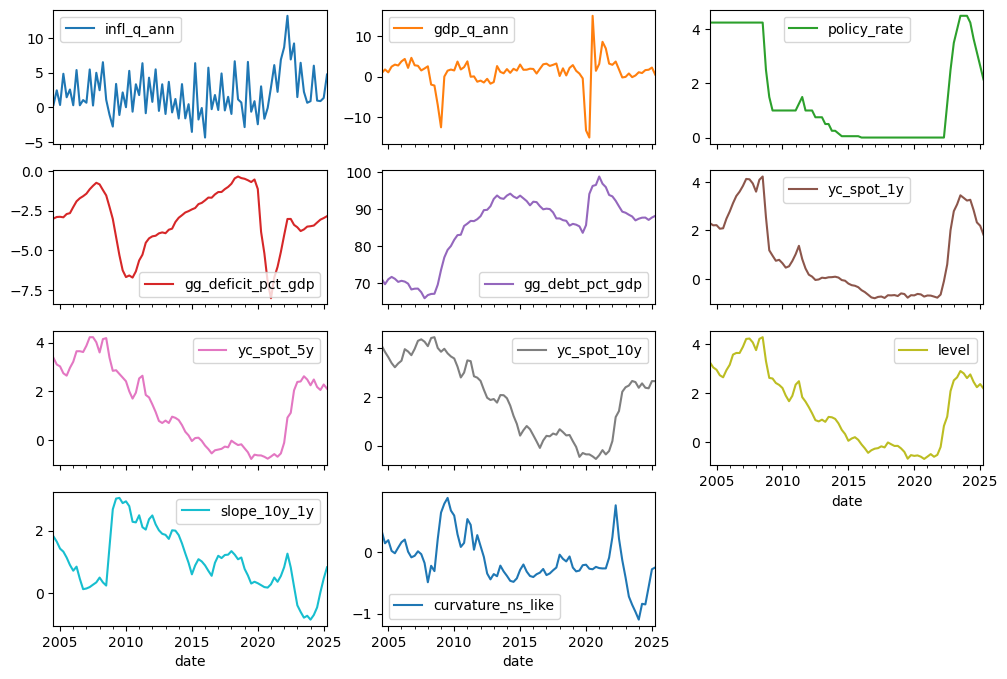

In [4]:
panel.plot(subplots=True, layout=(4,3), figsize=(12, 8), legend=True)

## 2) Bayesian reduced-form VAR

In this section we set up the reduced-form Bayesian VAR that will serve as the engine for all conditional forecasts. The idea is to have a flexible multivariate time-series model that captures the joint dynamics of the macro block (GDP, inflation) and the financial block (yield-curve factors).

Vector Autoregressions (VARs) are a core tool in empirical macroeconomics because they model how key economic and financial variables move together over time without requiring strong theoretical assumptions. By capturing the persistence, co-movement, and shock propagation between variables such as interest rates, inflation, GDP, and yield-curve factors, VARs provide a data-driven representation of macroeconomic dynamics. This makes them ideal for forecasting and policy analysis.

A Bayesian treatment is useful in our case because:

- the sample is not huge (quarterly data),

- we want to retain parameter uncertainty for scenario analysis,

- and we later need the full posterior to run conditional (Waggoner–Zha style) forecasts.

### Model

We model a VAR($p$) with exogenous dummies for COVID quarters:

- Let $y_t \in \mathbb{R}^K$ be the vector of endogenous variables at time $t$.
- Let $z_t \in \mathbb{R}^q$ be the vector of exogenous dummies (in this case the COVID quarters).
- Define the lagged regressor vector

$$
x_t =
\begin{bmatrix}
y_{t-1}^\prime & y_{t-2}^\prime & \dots & y_{t-p}^\prime
\end{bmatrix}^\prime
\in \mathbb{R}^{Kp}.
$$

The observation equation for $t = p+1,\dots,T$ is

$$
y_t = c + B x_t + \Gamma z_t + u_t, \qquad
u_t \sim \mathcal{N}(0,\Sigma),
$$

where:

- $c \in \mathbb{R}^K$ is the intercept,
- $B \in \mathbb{R}^{K \times Kp}$ stacks the VAR coefficients  
  $$
  B = \begin{bmatrix} A_1 & A_2 & \dots & A_p \end{bmatrix},
  $$
  with $A_\ell$ the $K\times K$ coefficient matrix on lag $\ell$,
- $\Gamma \in \mathbb{R}^{K \times q}$ collects the coefficients on the dummy regressors,
- $\Sigma \in \mathbb{R}^{K\times K}$ is the residual covariance matrix.

In our model we set $p=2$

---

### Priors

**Residual covariance (LKJ prior)**

Over the last decade, the LKJ prior has become the standard way to model correlation matrices in Bayesian multivariate analysis because it separates correlations from variances and avoids the strong, unintended constraints imposed by inverse-Wishart conjugate priors. Its simple shape parameter and compatibility with Cholesky factorization make it far more stable and interpretable, which is why probabilistic programming frameworks like PyMC, Stan, and TFP now use LKJ by default.

We parameterize $\Sigma$ via its Cholesky factor:

$$
L \sim \text{LKJCholeskyCov}(\eta = 2,\ \sigma),
\qquad
\Sigma = L L^\prime,
$$

with marginal scales

$$
\sigma_i \sim \text{HalfNormal}(1.0), \quad i = 1,\dots,K.
$$

---

### VAR coefficients with Minnesota-style scales

#### Overview of Minnesota priors

A key feature of Bayesian VARs in macroeconomics is the use of **Minnesota priors**, which impose structured shrinkage on the autoregressive coefficients.  
This prevents overfitting when the number of parameters is large relative to the time span of quarterly data, while still allowing the model to capture important dynamics. 
There are 3 shrinkage parameters: $\lambda_1$ which controls autoregressive behavior of the variable itself, $\lambda_2$ which controls cross-variable effects and $\lambda_3$ is responsible for the decay of longer lags.

The prior assumes that:

- each variable in the system follows its own autoregressive process (so own lags matter most),
- cross-variable lags are likely to have smaller coefficients,
- and coefficients on longer lags decay roughly as $1 / L^{\lambda_3}$.

Mathematically, the prior for each coefficient $\beta_{ijL}$ on variable $j$ at lag $L$ in equation $i$ is:

$$
\beta_{ijL} \sim \mathcal{N}(0, S_{ijL}^2),
$$

with scale

$$
S_{ijL} = \lambda_1 \frac{\sigma_i}{\sigma_j} \frac{\lambda_2^{\mathbf{1}(i \ne j)}}{L^{\lambda_3}},
$$

where:

- $\lambda_1$: **overall tightness** (smaller → stronger shrinkage; 0.2 is moderate),
- $\lambda_2$: **cross-variable penalty** (down-weights other variables’ lags),
- $\lambda_3$: **lag decay** (ensures higher lags are more heavily shrunk),
- $\sigma_i$: residual scale of variable \( i \), typically its standard deviation.

The prior shrinks coefficients on longer lags and on “unrelated” equations, which stabilizes forecasts and improves acceptance of sign/level constraints later.

Our MCMC setup (PyMC + NUTS) would allow us to set priors on the $\lambda$s themselves, but we leave them as fixed values for simplicity.

#### Minnesota priors in our model

For each element of $B$:

$$
B_{ij} \sim \mathcal{N}\bigl(0,\ S_{\beta,ij}^2\bigr),
$$

where the prior standard deviations $S_{\beta,ij}$ come from the Minnesota prior using the variable standard deviations and hyperparameters $\lambda_1, \lambda_2, \lambda_3$.

Compactly:

$$
B \sim \mathcal{N}(0,\ S_\beta \odot S_\beta),
$$

with $S_\beta \in \mathbb{R}^{K \times Kp}$ the matrix of prior scales.

---

### Intercept

$$
c \sim \mathcal{N}(0,\ 5^2 I_K).
$$

---

### Exogenous dummy coefficients

We use a global shrinkage prior:

$$
\tau_D \sim \text{HalfNormal}(0.5),
$$

$$
\Gamma_{ik} \sim \mathcal{N}(0,\ \tau_D^2), \qquad i = 1,\dots,K,\ k = 1,\dots,q.
$$

---

### Likelihood (stacked form)

Define the stacked matrices:

$$
Y = \begin{bmatrix} y_{p+1}^\prime \\ \vdots \\ y_T^\prime \end{bmatrix},
\qquad
X = \begin{bmatrix} x_{p+1}^\prime \\ \vdots \\ x_T^\prime \end{bmatrix},
\qquad
Z = \begin{bmatrix} z_{p+1}^\prime \\ \vdots \\ z_T^\prime \end{bmatrix}.
$$

The likelihood is:

$$
y_t \mid B,c,\Gamma,\Sigma \sim \mathcal{N}(\mu_t,\Sigma),
\qquad
\mu_t = c + B x_t + \Gamma z_t.
$$

### Posterior objects

The estimation returns an `arviz.InferenceData` object (`idata`) with, for each posterior draw:

- the stacked coefficient matrix $B=[A_1, \ldots, A_p]$

- the intercept $c$

- the covariance matrix $\Sigma$

These are exactly the ingredients we need to:

- build the companion form and unconditional forecasts,

- impose linear constraints for Basel yield paths,

- re-simulate conditional distributions of future $y_{t+h}$

### Code

For Bayesian estimation, this project uses the PyMC probabilistic programming framework and the ArviZ diagnostics library.

PyMC provides a Python-native interface for defining Bayesian models directly in terms of probability distributions.
It relies on advanced Markov Chain Monte Carlo (MCMC) and variational inference backends, allowing scalable sampling even for high-dimensional models like Bayesian VARs.
Its integration with NumPy and Theano/PyTensor makes it easy to vectorize likelihoods and run efficient, gradient-based samplers such as NUTS (No-U-Turn Sampler).

ArviZ complements PyMC by offering powerful posterior analysis and visualization tools: trace plots, posterior predictive checks, and convergence diagnostics such as $\hat{R}$ and effective sample size.
It standardizes outputs through the `InferenceData` object, which stores chains, priors, and observed data in an easily accessible format.

Together, PyMC and ArviZ make it possible to:

- Estimate fully Bayesian macroeconomic models with proper uncertainty quantification,

- Reuse posterior draws for scenario simulations (conditional forecasts),

- Integrate seamlessly into a Python-based data and visualization pipeline.

With this, the BVAR section of our project does the following:

1. estimate the BVAR model

2. load the saved BVAR posterior (`idata`),

3. extract $B$, $c$, and $\Sigma$ for all posterior draws,

4. read the lag order $p$,

5. and define the `var_order` vector that will be used consistently in the rest of the notebook.

We model a VAR($p$) with exogenous dummies:

- Let $y_t \in \mathbb{R}^K$ be the vector of endogenous variables at time $t$.
- Let $z_t \in \mathbb{R}^q$ be the vector of exogenous dummies (in this case the COVID quarters).
- Define the lagged regressor vector

$$
x_t =
\begin{bmatrix}
y_{t-1}^\prime & y_{t-2}^\prime & \dots & y_{t-p}^\prime
\end{bmatrix}^\prime
\in \mathbb{R}^{Kp}.
$$

The observation equation for $t = p+1,\dots,T$ is

$$
y_t = c + B x_t + \Gamma z_t + u_t, \qquad
u_t \sim \mathcal{N}(0,\Sigma),
$$

where:

- $c \in \mathbb{R}^K$ is the intercept,
- $B \in \mathbb{R}^{K \times Kp}$ stacks the VAR coefficients  
  $$
  B = \begin{bmatrix} A_1 & A_2 & \dots & A_p \end{bmatrix},
  $$
  with $A_\ell$ the $K\times K$ coefficient matrix on lag $\ell$,
- $\Gamma \in \mathbb{R}^{K \times q}$ collects the coefficients on the dummy regressors,
- $\Sigma \in \mathbb{R}^{K\times K}$ is the residual covariance matrix.

---

### Priors

**Residual covariance (LKJ prior)**

We parameterize $\Sigma$ via its Cholesky factor:

$$
L \sim \text{LKJCholeskyCov}(\eta = 2,\ \sigma),
\qquad
\Sigma = L L^\prime,
$$

with marginal scales

$$
\sigma_i \sim \text{HalfNormal}(1.0), \quad i = 1,\dots,K.
$$

---

### VAR coefficients with Minnesota-style scales

For each element of $B$:

$$
B_{ij} \sim \mathcal{N}\bigl(0,\ S_{\beta,ij}^2\bigr),
$$

where the prior standard deviations $S_{\beta,ij}$ come from the Minnesota prior using the variable standard deviations and hyperparameters $\lambda_1, \lambda_2, \lambda_3$.

Compactly:

$$
B \sim \mathcal{N}(0,\ S_\beta \odot S_\beta),
$$

with $S_\beta \in \mathbb{R}^{K \times Kp}$ the matrix of prior scales.

---

### Intercept

$$
c \sim \mathcal{N}(0,\ 5^2 I_K).
$$

---

### Exogenous dummy coefficients

We use a global shrinkage prior:

$$
\tau_D \sim \text{HalfNormal}(0.5),
$$

$$
\Gamma_{ik} \sim \mathcal{N}(0,\ \tau_D^2), \qquad i = 1,\dots,K,\ k = 1,\dots,q.
$$

---

### Likelihood (stacked form)

Define the stacked matrices:

$$
Y = \begin{bmatrix} y_{p+1}^\prime \\ \vdots \\ y_T^\prime \end{bmatrix},
\qquad
X = \begin{bmatrix} x_{p+1}^\prime \\ \vdots \\ x_T^\prime \end{bmatrix},
\qquad
Z = \begin{bmatrix} z_{p+1}^\prime \\ \vdots \\ z_T^\prime \end{bmatrix}.
$$

The likelihood is:

$$
y_t \mid B,c,\Gamma,\Sigma \sim \mathcal{N}(\mu_t,\Sigma),
\qquad
\mu_t = c + B x_t + \Gamma z_t.
$$


## 2) Bayesian reduced-form VAR

In this section we set up the reduced-form Bayesian VAR that will serve as the engine for all conditional forecasts. The idea is to have a flexible multivariate time-series model that captures the joint dynamics of the macro block (GDP, inflation) and the financial block (yield-curve factors).

### Model

We use a VAR(p) of the form

$$
y_t = c + A_1 y_{t-1} + \dots + A_p y_{t-p} + u_t, \quad u_t \sim \mathcal{N}(0, \Sigma),
$$

where $y_t$ stacks the variables from the panel.

A Bayesian treatment is useful here because:

- the sample is not huge (quarterly data),

- we want to retain parameter uncertainty for scenario analysis,

- and we later need the full posterior to run conditional (Waggoner–Zha style) forecasts.

### Priors and lags

A key feature of Bayesian VARs in macroeconomics is the use of **Minnesota priors**, which impose structured shrinkage on the autoregressive coefficients.  
This prevents overfitting when the number of parameters is large relative to the time span of quarterly data, while still allowing the model to capture important dynamics. 
There are 3 shrinkage parameters: $\lambda_1$ which controls autoregressive behavior of the variable itself, $\lambda_2$ which controls cross-variable effects and $\lambda_3$ is responsible for the decay of longer lags.

The prior assumes that:

- each variable in the system follows its own autoregressive process (so own lags matter most),
- cross-variable lags are likely to have smaller coefficients,
- and coefficients on longer lags decay roughly as $1 / L^{\lambda_3}$.

Mathematically, the prior for each coefficient $\beta_{ijL}$ on variable $j$ at lag $L$ in equation $i$ is:

$$
\beta_{ijL} \sim \mathcal{N}(0, s_{ijL}^2),
$$

with scale

$$
s_{ijL} = \lambda_1 \frac{\sigma_i}{\sigma_j} \frac{\lambda_2^{\mathbf{1}(i \ne j)}}{L^{\lambda_3}},
$$

where:

- $\lambda_1$: **overall tightness** (smaller → stronger shrinkage; 0.2 is moderate),
- $\lambda_2$: **cross-variable penalty** (down-weights other variables’ lags),
- $\lambda_3$: **lag decay** (ensures higher lags are more heavily shrunk),
- $\sigma_i$: residual scale of variable \( i \), typically its standard deviation.


The prior shrinks coefficients on longer lags and on “unrelated” equations, which stabilizes forecasts and improves acceptance of sign/level constraints later.

Our MCMC setup would allow us to set priors on the $\lambda$s themselves, but we leave them as fixed values for simplicity.

### Posterior objects

The estimation returns an `arviz.InferenceData` object (`idata`) with, for each posterior draw:

- the stacked coefficient matrix $B=[A_1, \ldots, A_p]$

- the intercept $c$

- the covariance matrix $\Sigma$

These are exactly the ingredients we need to:

- build the companion form and unconditional forecasts,

- impose linear constraints for Basel yield paths,

- re-simulate conditional distributions of future $y_{t+h}$

### Code

For Bayesian estimation, this project uses the PyMC probabilistic programming framework and the ArviZ diagnostics library.

PyMC provides a Python-native interface for defining Bayesian models directly in terms of probability distributions.
It relies on advanced Markov Chain Monte Carlo (MCMC) and variational inference backends, allowing scalable sampling even for high-dimensional models like Bayesian VARs.
Its integration with NumPy and Theano/PyTensor makes it easy to vectorize likelihoods and run efficient, gradient-based samplers such as NUTS (No-U-Turn Sampler).

ArviZ complements PyMC by offering powerful posterior analysis and visualization tools: trace plots, posterior predictive checks, and convergence diagnostics such as $\hat{R}$ and effective sample size.
It standardizes outputs through the `InferenceData` object, which stores chains, priors, and observed data in an easily accessible format.

Together, PyMC and ArviZ make it possible to:

- Estimate fully Bayesian macroeconomic models with proper uncertainty quantification,

- Reuse posterior draws for scenario simulations (conditional forecasts),

- Integrate seamlessly into a Python-based data and visualization pipeline.

With this, the BVAR section of our project does the following:

1. estimate the BVAR model

2. load the saved BVAR posterior (`idata`),

3. extract $B$, $c$, and $\Sigma$ for all posterior draws,

4. read the lag order $p$,

5. and define the `var_order` vector that will be used consistently in the rest of the notebook.

In [5]:
from src import bvar

C:\Users\thoma\.conda\envs\pymc_env\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


Specification of our model:

`pm.model_to_graphviz` allows us to have a simple graph of our Bayesian model

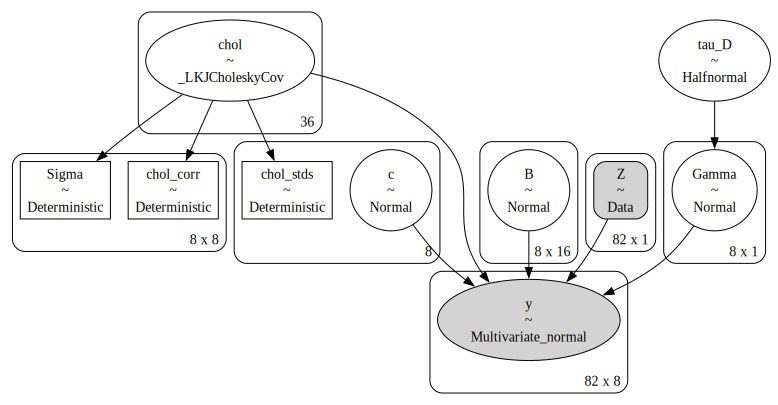

In [6]:
# 1) Load data (you already created this file)
df = panel

vars_used = [
    "infl_q_ann","gdp_q_ann","policy_rate","gg_deficit_pct_gdp","gg_debt_pct_gdp",
    "level","slope_10y_1y","curvature_ns_like"
]
Ydf = df[vars_used].dropna()
Y = Ydf.to_numpy()
T, K = Y.shape

# 2) Build lag matrices

p = 2
X, Yt = bvar.build_var_design(Y, p)        # X=(T_eff, K*p), Yt=(T_eff, K)
T_eff = Yt.shape[0]

# 3) Minnesota-style prior scales (simple, effective defaults)

S_beta = bvar.minnesota_scales(K, p, sigma=Ydf.std().values, lam1=0.20, lam2=0.5, lam3=1.0)

# 4) PyMC model (LKJ Cholesky prior on Σu; gallery pattern)

with pm.Model() as bvar_model:
    # Residual covariance Σu with LKJ prior
    sd_dist = pm.HalfNormal.dist(1.0, shape=K)
    chol, corr, sds = pm.LKJCholeskyCov(
        "chol", n=K, eta=2.0, sd_dist=sd_dist, compute_corr=True, store_in_trace=True
    )
    Sigma = pm.Deterministic("Sigma", chol @ chol.T)

    # Coefficients: B is K x (K*p); intercept c is K
    B = pm.Normal("B", mu=0.0, sigma=S_beta, shape=(K, K * p))
    c = pm.Normal("c", mu=0.0, sigma=5.0, shape=K)
    
    # COVID dummy
    Z = np.zeros((T-p, 1), dtype=float)
    Z[[63-p, 64-p], 0] = 1.0
    q = Z.shape[1]                 # number of dummy columns (1 or 2)
    Z_shared = pm.Data("Z", Z)     # register as data for PyMC

    # Coefficients for exogenous block: Γ has shape (K x q), one coefficient per VAR equation per dummy
    tau_D = pm.HalfNormal("tau_D", sigma=0.5)   # global shrinkage
    Gamma = pm.Normal("Gamma", mu=0.0, sigma=tau_D, shape=(K, q))

    # Mean and likelihood (vectorized over T_eff rows)
    mu = c + pt.dot(X, B.T) + pt.dot(Z_shared, Gamma.T) # (T_eff, K)
    pm.MvNormal("y", mu=mu, chol=chol, observed=Yt)     # use chol for stability

pm.model_to_graphviz(bvar_model)

Modern Bayesian inference relies heavily on gradient-based Monte Carlo algorithms, which offer far better efficiency than classical random-walk MCMC. PyMC uses Hamiltonian Monte Carlo (HMC) and its adaptive variant, the No-U-Turn Sampler (NUTS), to explore high-dimensional posterior distributions quickly and with minimal tuning. HMC treats sampling as a physics problem—following simulated “trajectories” informed by the posterior’s gradients—allowing it to take large, informed steps and avoid the slow diffusion of traditional MCMC. NUTS improves on HMC by automatically adjusting trajectory lengths, removing the need for manual tuning. Under the hood, PyMC can now run these algorithms through BlackJAX, a JAX-based engine that provides fast, differentiable, and hardware-accelerated (CPU/GPU) implementations of HMC/NUTS. This combination delivers stable, scalable Bayesian inference even for complex models such as high-dimensional VARs.

For our sampling we use BlackJAX, but configure a logical check to fall back to the standard PyMC sampler if issues arise

In [7]:
# Sampler (BlackJAX NUTS if installed; fallback to pm.sample)
from pymc.sampling.jax import sample_blackjax_nuts
import jax
jax.config.update("jax_enable_x64", True)  # recommended for numerical stability
with bvar_model:
    try:
        idata = sample_blackjax_nuts(draws=5000, tune=1500, chains=4, target_accept=0.9, random_seed=123, idata_kwargs={"log_likelihood": True})
    except Exception:
        idata = pm.sample(2000, nuts_sampler="numpyro", init="jitter+adapt_diag", tune=1000, chains=4, target_accept=0.9, adapt_step_size=True, random_seed=123, idata_kwargs={"log_likelihood": True})
az.to_netcdf(idata, "results/bvar_results.nc")

Running window adaptation


There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


'results/bvar_results.nc'

In [8]:
idata = az.from_netcdf("results/bvar_results.nc")

In [9]:
# Quick numeric summary
az.summary(idata, var_names=["B", "Sigma", "tau_D"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"B[0, 0]",-0.05,0.09,-0.22,0.12,0.00,0.00,34508.91,15595.07,1.00
"B[0, 1]",0.03,0.06,-0.08,0.15,0.00,0.00,35988.23,15182.45,1.00
"B[0, 2]",0.04,0.15,-0.25,0.33,0.00,0.00,36379.85,15787.18,1.00
"B[0, 3]",-0.13,0.13,-0.37,0.13,0.00,0.00,37043.68,15445.59,1.00
"B[0, 4]",0.01,0.03,-0.04,0.06,0.00,0.00,31890.49,15737.98,1.00
...,...,...,...,...,...,...,...,...,...
"Sigma[7, 4]",0.01,0.02,-0.03,0.05,0.00,0.00,19580.68,15138.91,1.00
"Sigma[7, 5]",0.01,0.01,0.00,0.02,0.00,0.00,20463.01,15936.13,1.00
"Sigma[7, 6]",0.03,0.01,0.02,0.04,0.00,0.00,20297.54,15365.98,1.00
"Sigma[7, 7]",0.03,0.01,0.02,0.04,0.00,0.00,20681.92,14776.48,1.00


array([[<Axes: title={'center': 'tau_D'}>,
        <Axes: title={'center': 'tau_D'}>],
       [<Axes: title={'center': 'B'}>, <Axes: title={'center': 'B'}>]],
      dtype=object)

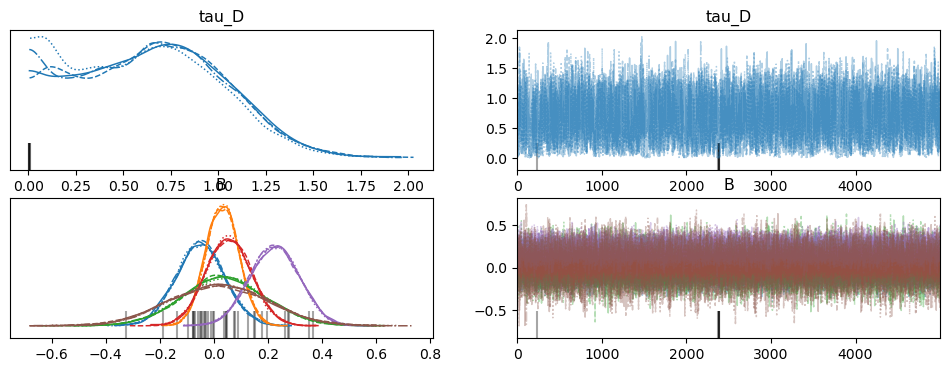

In [10]:
coords = {"B_dim_0": [0, 1], "B_dim_1": [0, 1, 2]} # adjust to dims

az.plot_trace(
    idata,
    var_names=["tau_D", "B"],
    coords=coords,
)

In [11]:
idata.attrs["vars_used"] = vars_used
idata.attrs["lags"] = p

var_order = [
    "infl_q_ann","gdp_q_ann","policy_rate","gg_deficit_pct_gdp","gg_debt_pct_gdp",
    "level","slope_10y_1y","curvature_ns_like"
]

## 3) Structural VAR (SVAR) and sign restrictions

The reduced-form BVAR gives us correlations and dynamics, but not **economic shocks**. To tell monetary, fiscal, or financial shocks apart we need to impose identifying restrictions, i.e., map reduced-form errors $u_t$ into structural shocks $\varepsilon_t$ with a causal, economic meaning.

In a reduced-form VAR we have
$$
u_t \sim \mathcal{N}(0, \Sigma_u),
$$
but we want a representation
$$
u_t = C \varepsilon_t, \quad \varepsilon_t \sim \mathcal{N}(0, I),
$$
where the columns of $C$ describe the instantaneous effect of each structural shock on the variables. Since many different $C$ matrices can produce the same $\Sigma_u = C C'$, we need extra **identifying restrictions**.

Structural VARs (SVARs) aim to recover economically meaningful shocks, such as monetary tightening or fiscal expansion, from the reduced-form errors of a standard VAR. The key challenge is that the reduced-form residuals only give us a covariance matrix $\Sigma_u$, and infinitely many structural decompositions are consistent with it. Identification requires additional assumptions to select a unique (or at least interpretable) mapping from reduced-form shocks to structural shocks. Classical approaches imposed zero restrictions (e.g., Cholesky ordering) or long-run restrictions, but these often rely on strong and potentially arbitrary modeling choices. Over the last two decades, sign restrictions have become a widely used alternative: instead of specifying exact zero patterns, we require the impulse responses of certain variables to have economically plausible signs (e.g., interest rates rise after a monetary tightening, output falls). This produces a set of admissible structural models rather than a single one and greatly reduces the risk of misspecification. In practice, identification proceeds by generating many candidate decompositions of $\Sigma_u$ using random rotations and keeping only those whose impulse responses satisfy the chosen sign patterns. This approach originated with Uhlig (2005) and was further developed by Rubio-Ramírez, Waggoner, and Zha (2010) and it is flexible, transparent, and aligns naturally with our probabilistic programming setting.

---

### Why sign restrictions?

Classical SVAR identification schemes (Cholesky ordering, long-run restrictions) often impose **too much structure** or force an arbitrary ordering of variables. **Sign restrictions** (Uhlig, 2005; Rubio-Ramírez, Waggoner and Zha, 2010) are more flexible:

- the researcher only specifies the **direction** of the response of some variables to a shock,
- over a short horizon (e.g. 0–4 quarters),
- without fixing the exact magnitude.

Examples:

- a **monetary tightening** shock: policy rate ↑, output ↓ or non-positive, prices ↓ or non-positive;
- a **fiscal expansion** shock: government spending ↑, output ↑, maybe interest rates ↑.

This is attractive for macro-finance because we usually know the **sign** of the effect better than we know its exact size.

---

### How it works in our framework

Because we already have a posterior over $(B, \Sigma_u)$ from the BVAR, sign restrictions become a **post-processing step**: for each posterior draw we generate candidate structural decompositions and keep only the ones whose IRFs satisfy our sign pattern.

The workflow is:

1. **Draw reduced-form parameters from the posterior**  
   We already have this in the `idata` object.

2. **Generate candidate impact matrices**  
   For a given $\Sigma_u$ we can write $ \Sigma_u = P P' $ (Cholesky, or any square root). Any orthonormal rotation $Q$ gives another valid decomposition
   $$
   C = P Q,
   $$
   so by drawing random orthonormal $Q$ we generate many candidate structural models.  
   In code this is what `make_candidates_from_idata(...)` does: for each posterior draw it builds candidate $C$ matrices (and the associated IRFs) by applying random rotations.

3. **Compute IRFs for each candidate**  
   Using the VAR coefficients and each candidate $C$, we simulate impulse responses over a small horizon, say 0–12 quarters.

4. **Apply the sign restrictions**  
   We define a simple dictionary of desired signs by variable and horizon (e.g. policy_rate: positive at h=0..1, output: non-positive at h=0..4).  
   The function `apply_sign_restrictions(...)` then checks, for each candidate IRF, whether all sign conditions are satisfied. If yes, we **accept** the candidate; otherwise we discard it.

5. **Collect accepted scenarios**  
   The accepted draws are stored in a dictionary (like `accepted_macro`) and can be used just like the Basel scenarios: to build conditional forecasts, to convert to a `df_all`-like long format, and finally to feed into the NII/EVE layer.

---

### Why it’s easy to integrate here

- We already sample the **full posterior** of the VAR, so we don’t need to re-estimate anything for SVAR — we simply rotate each posterior draw.
- The sign-checking step is vectorized and can be written in a few lines of NumPy.
- The output structure (`accepted_macro`) mirrors the one we used for Basel, so later on we can **reuse** the same plotting and the same NII/EVE mapping.

In other words, once the BVAR is estimated, adding structural identification is just: *“generate candidates → filter by signs → store accepted draws.”* This is why sign-restricted SVARs are so popular in applied macro today.


In [12]:
from src import svar

In [13]:
idata = az.from_netcdf("results/bvar_results.nc")
cands = svar.make_candidates_from_idata(
    idata=idata,
    p=idata.attrs.get("lags", 2),
    H=20,
    max_draws=5000,
    rotations_per_draw=50,
    require_stable=True,
    seed=123
)

print("Candidates generated:", len(cands["C"]))
print("Shapes B, Sigma, C, IRFs:", cands["B"].shape, cands["Sigma"].shape, cands["C"].shape, cands["IRFs"].shape)

Candidates generated: 214750
Shapes B, Sigma, C, IRFs: (214750, 8, 16) (214750, 8, 8) (214750, 8, 8) (214750, 21, 8, 8)


These are our two sets of sign restrictions for our SVAR for each of our macroeconomic scenarios: fiscal expansion and monetary tightening

### Fiscal Expansion Sign Restrictions

| Variable   | Horizon (q) | Sign | Economic Meaning |
|------------|-------------|------|------------------|
| deficit    | 0–2         | –    | Deficit increases (deficits are negative, so a rise is more negative) |
| level      | 0           | +    | Interest-rate level rises on impact |
| inflation  | 1–4         | +    | Inflation increases within year 1 |
| GDP        | 1–4         | +    | Output rises with a lag |
| debt       | 2–6         | +    | Debt ratio rises over 0.5–2 years |
| (others)   | —           | free | No restriction on slope, curvature, policy |

### Monetary Tightening Sign Restrictions

| Variable      | Horizon (q) | Sign | Economic Meaning |
|---------------|-------------|------|------------------|
| policy rate   | 0           | +    | Policy rate jumps (tightening) |
| slope         | 0–2         | –    | Yield curve flattens |
| inflation     | 1–4         | –    | Disinflation within year 1 |
| GDP           | 1–4         | –    | Output falls with a lag |
| (others)      | —           | free | Level, deficit, debt, curvature unrestricted |

In [14]:
spec_fiscal, spec_monet = svar.build_sign_specs_8var()

accepted_fiscal = svar.apply_sign_restrictions(
    cands, spec_one_shock=spec_fiscal, shock_name="fiscal_expansion",
    max_accept=5000, tol_zero=1e-8
)
print("Fiscal: accepted", accepted_fiscal["accepted"], "of", accepted_fiscal["tried"],
      f"(rate={accepted_fiscal['accept_rate']:.2%})")

accepted_monet = svar.apply_sign_restrictions(
    cands, spec_one_shock=spec_monet, shock_name="monetary_tightening",
    max_accept=5000, tol_zero=1e-8
)
print("Monetary: accepted", accepted_monet["accepted"], "of", accepted_monet["tried"],
      f"(rate={accepted_monet['accept_rate']:.2%})")

Fiscal: accepted 5000 of 95856 (rate=5.22%)
Monetary: accepted 5000 of 71277 (rate=7.01%)


In [15]:
accepted_macro = {'fiscal_expansion' : accepted_fiscal, "monetary_tightening" : accepted_monet}

accF = accepted_macro["fiscal_expansion"]
alphas_1sd_fisc, sig_def_f = svar.alphas_one_sigma(accF, panel, var_order, "gg_deficit_pct_gdp")

# Fiscal expansion, 1σ on deficit
accM = accepted_macro["monetary_tightening"]
alphas_1sd_monet, sig_pol_m = svar.alphas_one_sigma(accM, panel, var_order, "policy_rate")


f_med, f_lo, f_hi, df_irf_fiscal  = svar.summarize_irfs(accepted_fiscal, var_order, H=20, alpha_scaling=alphas_1sd_fisc)
m_med, m_lo, m_hi, df_irf_monet   = svar.summarize_irfs(accepted_monet, var_order, H=20, alpha_scaling=alphas_1sd_monet)

Impulse Response Functions (IRFs) show how each variable in a VAR responds over time to a one-unit structural shock, such as a monetary tightening or a fiscal expansion. An IRF traces the dynamic path of the system: it answers “if this shock hits today, how will interest rates, GDP, inflation, and other variables evolve over the next quarters?” Because VARs capture the interactions and propagation mechanisms among variables, IRFs provide a transparent way to study causal effects in macroeconomics. They are the core tool used to interpret structural shocks and to evaluate policy transmission.

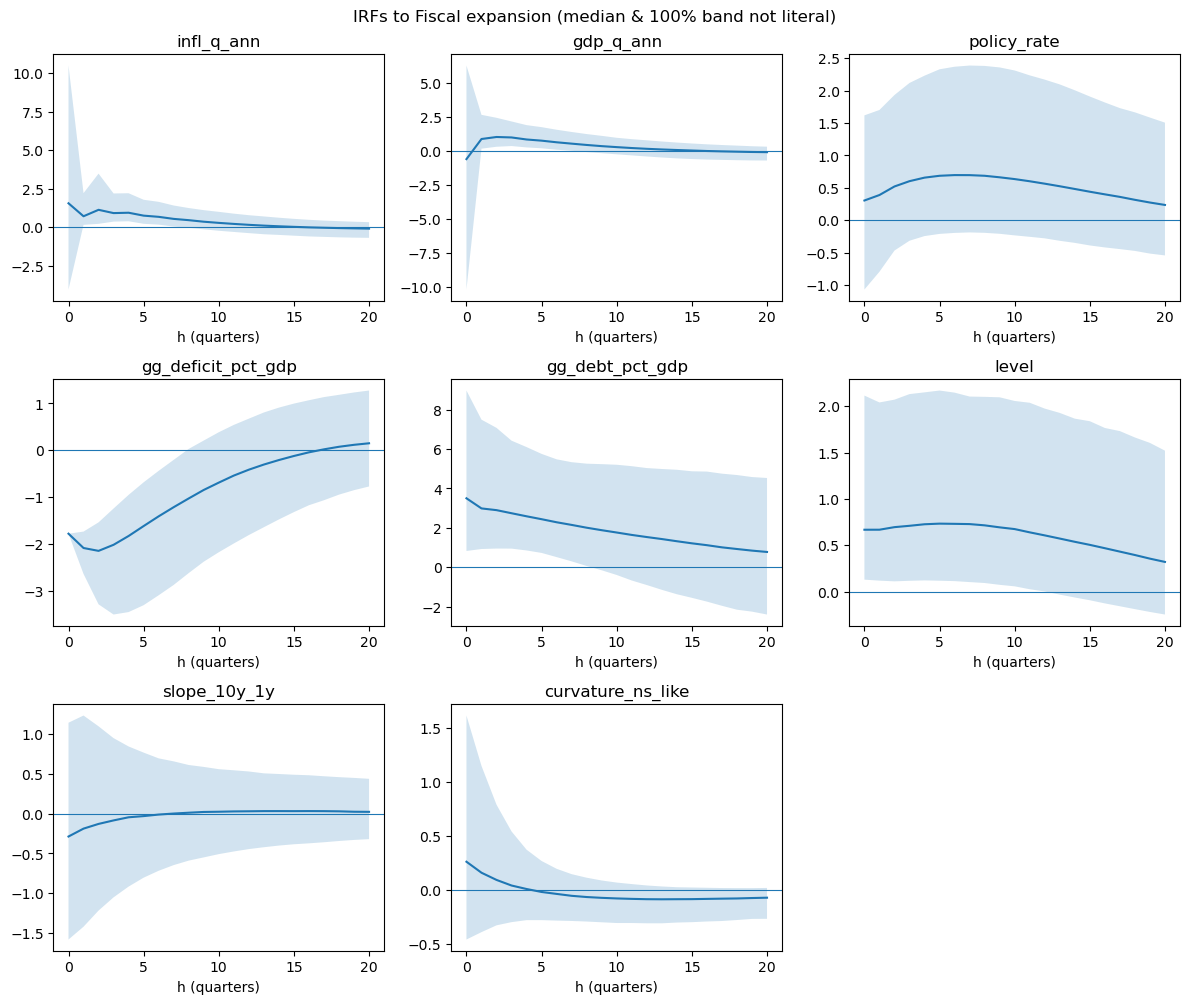

In [16]:
svar.plot_irf_panel(f_med, f_lo, f_hi, var_order, shock_label="Fiscal expansion")
plt.show()

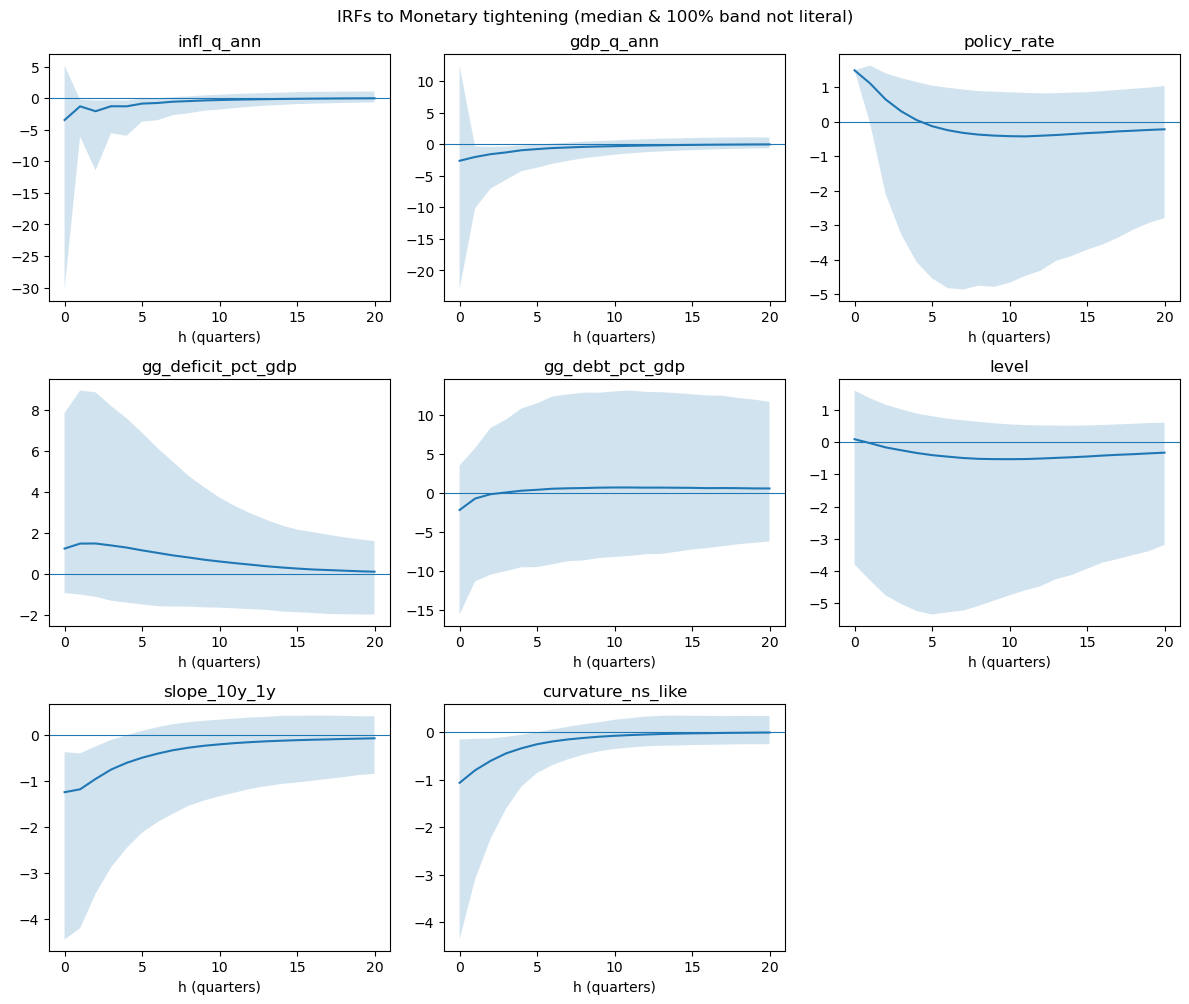

In [17]:
svar.plot_irf_panel(m_med, m_lo, m_hi, var_order, shock_label="Monetary tightening")
plt.show()

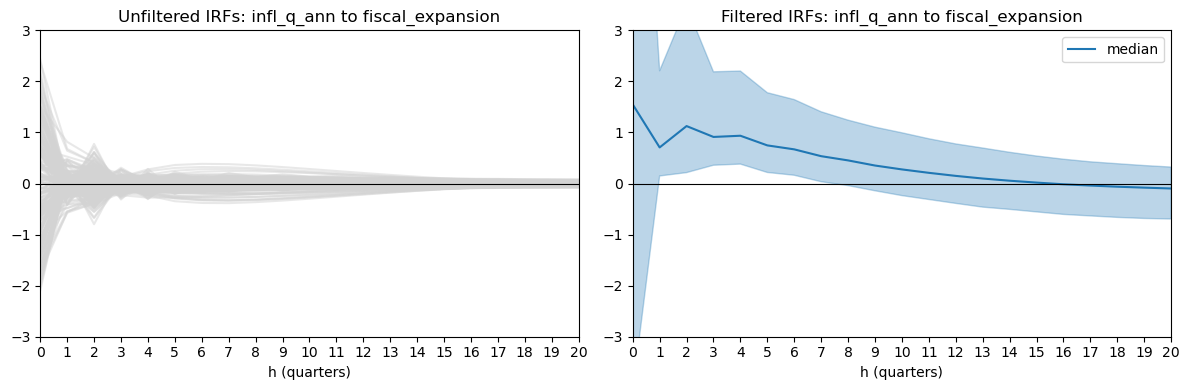

In [18]:
svar.plot_irf_comparison(cands["IRFs"][:, :, :, 3], df_irf_fiscal, "fiscal_expansion",
                    var="infl_q_ann", var_idx=0, H=20)
plt.show()

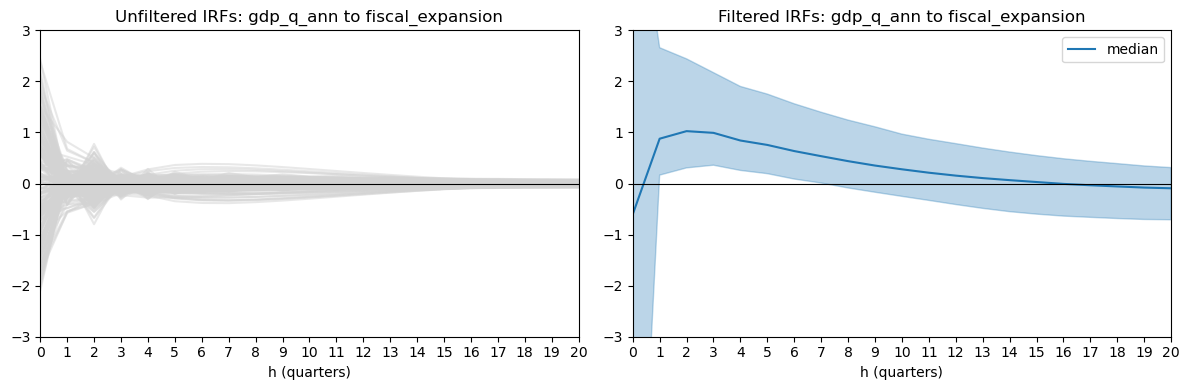

In [19]:
svar.plot_irf_comparison(cands["IRFs"][:, :, :, 3], df_irf_fiscal, "fiscal_expansion",
                    var="gdp_q_ann", var_idx=0, H=20)
plt.show()

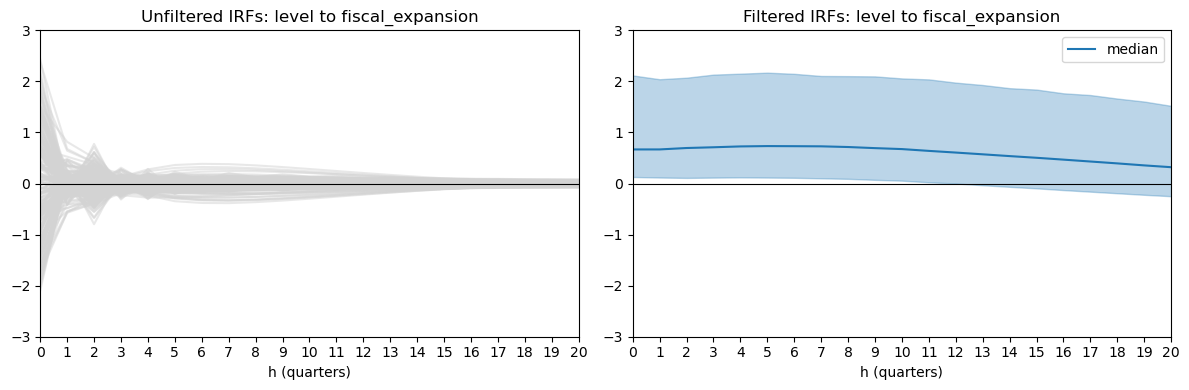

In [20]:
svar.plot_irf_comparison(cands["IRFs"][:, :, :, 3], df_irf_fiscal, "fiscal_expansion",
                    var="level", var_idx=0, H=20)
plt.show()

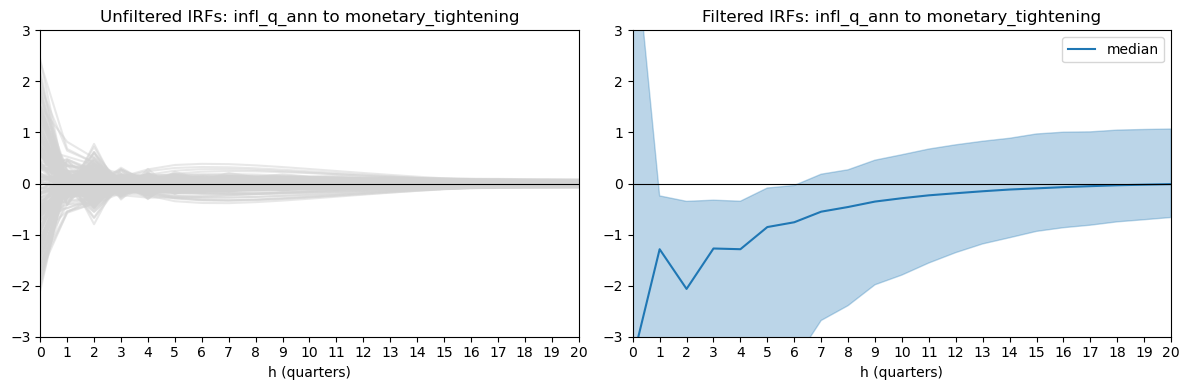

In [21]:
svar.plot_irf_comparison(cands["IRFs"][:, :, :, 3], df_irf_monet, "monetary_tightening",
                    var="infl_q_ann", var_idx=0, H=20)
plt.show()

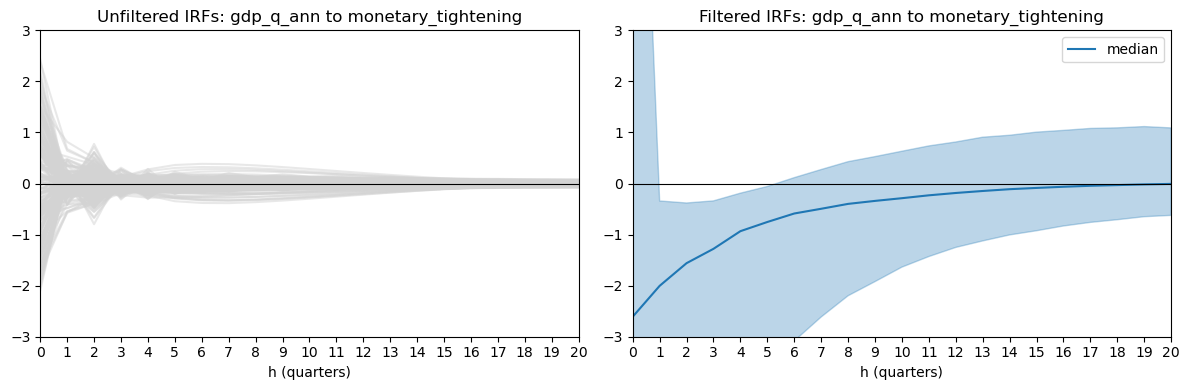

In [22]:
svar.plot_irf_comparison(cands["IRFs"][:, :, :, 3], df_irf_monet, "monetary_tightening",
                    var="gdp_q_ann", var_idx=0, H=20)
plt.show()

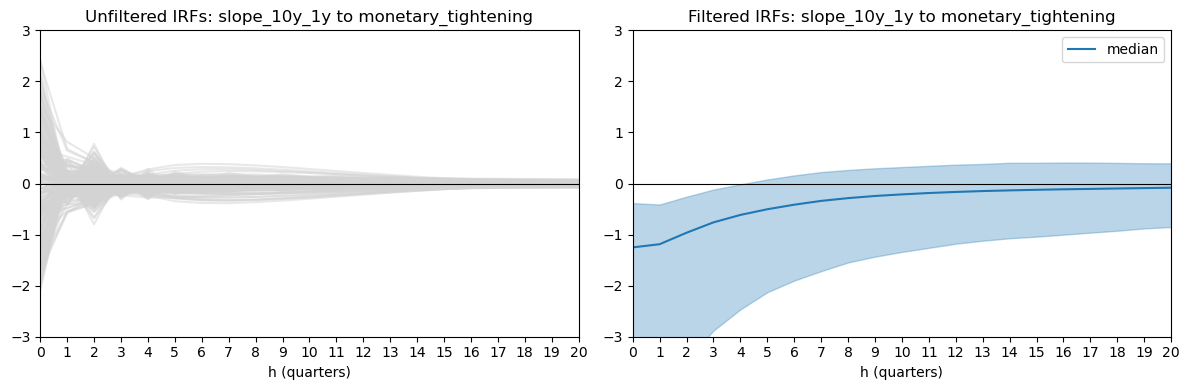

In [23]:
svar.plot_irf_comparison(cands["IRFs"][:, :, :, 3], df_irf_monet, "monetary_tightening",
                    var="slope_10y_1y", var_idx=0, H=20)
plt.show()

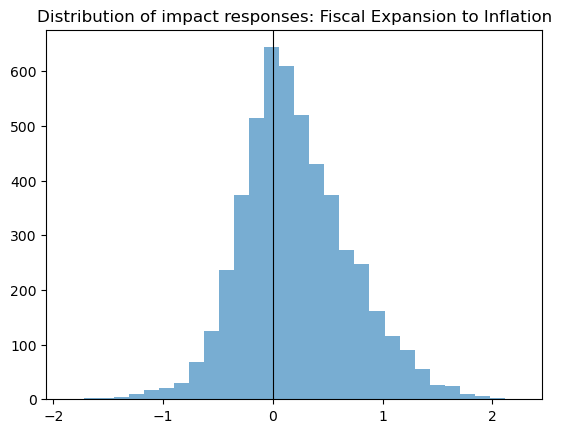

In [24]:
svar.plot_hist_impact(accepted_fiscal, 0, "Fiscal Expansion", "Inflation")

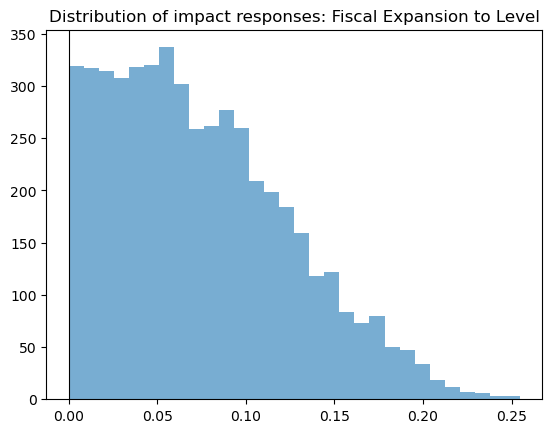

In [25]:
svar.plot_hist_impact(accepted_fiscal, 5, "Fiscal Expansion", "Level")

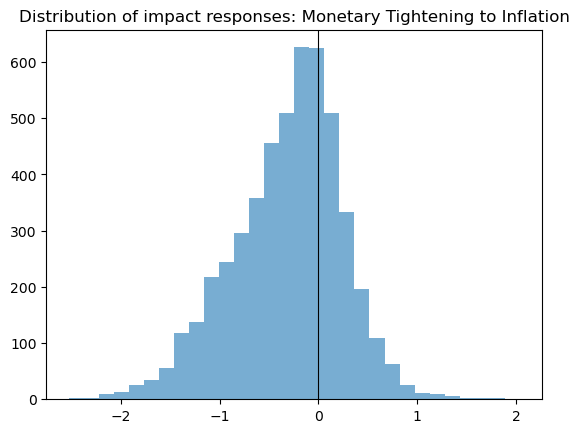

In [26]:
svar.plot_hist_impact(accepted_monet, 0, "Monetary Tightening", "Inflation")

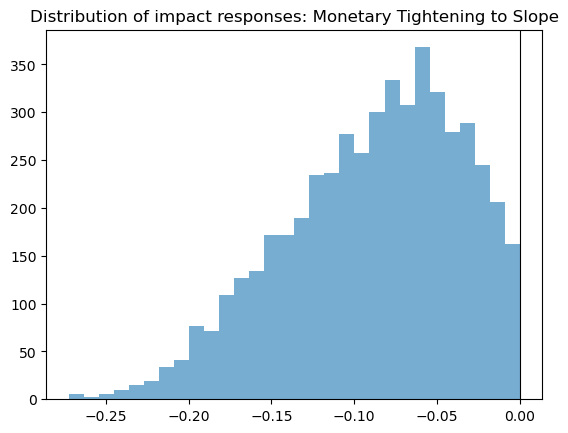

In [27]:
svar.plot_hist_impact(accepted_monet, 6, "Monetary Tightening", "Slope")

In [28]:
rep_fiscal  = svar.quick_diag_summary(accepted_fiscal,  var_order, "Fiscal expansion")
rep_monet   = svar.quick_diag_summary(accepted_monet,   var_order, "Monetary tightening")


=== Diagnostics summary: Fiscal expansion ===
Accepted: 5000 / 95856 (5.22% rate)
Median impact responses (h=0):
  infl_q_ann          : {'median': np.float64(0.157), 'p10': np.float64(-0.361), 'p90': np.float64(0.877)}
  gdp_q_ann           : {'median': np.float64(-0.058), 'p10': np.float64(-0.941), 'p90': np.float64(0.549)}
  policy_rate         : {'median': np.float64(0.034), 'p10': np.float64(-0.083), 'p90': np.float64(0.147)}
  gg_deficit_pct_gdp  : {'median': np.float64(-0.185), 'p10': np.float64(-0.278), 'p90': np.float64(-0.082)}
  gg_debt_pct_gdp     : {'median': np.float64(0.366), 'p10': np.float64(0.085), 'p90': np.float64(0.618)}
  level               : {'median': np.float64(0.067), 'p10': np.float64(0.013), 'p90': np.float64(0.147)}
  slope_10y_1y        : {'median': np.float64(-0.031), 'p10': np.float64(-0.145), 'p90': np.float64(0.089)}
  curvature_ns_like   : {'median': np.float64(0.028), 'p10': np.float64(-0.051), 'p90': np.float64(0.1)}

=== Diagnostics summary: Mone

In [29]:
table_fiscal  = svar.diag_table(accepted_fiscal,  var_order, "Fiscal expansion")
table_monet   = svar.diag_table(accepted_monet,   var_order, "Monetary tightening")

# Combine into one table for display
diag_tables = pd.concat([table_fiscal, table_monet], ignore_index=True)
diag_tables.round(2)

,shock,var,median,p10,p90,accepted,tried,accept_rate
0,Fiscal expansion,infl_q_ann,0.16,-0.36,0.88,5000,95856,5.22%
1,Fiscal expansion,gdp_q_ann,-0.06,-0.94,0.55,5000,95856,5.22%
2,Fiscal expansion,policy_rate,0.03,-0.08,0.15,5000,95856,5.22%
3,Fiscal expansion,gg_deficit_pct_gdp,-0.18,-0.28,-0.08,5000,95856,5.22%
4,Fiscal expansion,gg_debt_pct_gdp,0.37,0.08,0.62,5000,95856,5.22%
5,Fiscal expansion,level,0.07,0.01,0.15,5000,95856,5.22%
6,Fiscal expansion,slope_10y_1y,-0.03,-0.14,0.09,5000,95856,5.22%
7,Fiscal expansion,curvature_ns_like,0.03,-0.05,0.10,5000,95856,5.22%
8,Monetary tightening,infl_q_ann,-0.24,-1.08,0.33,5000,71277,7.01%
9,Monetary tightening,gdp_q_ann,-0.19,-1.01,0.63,5000,71277,7.01%


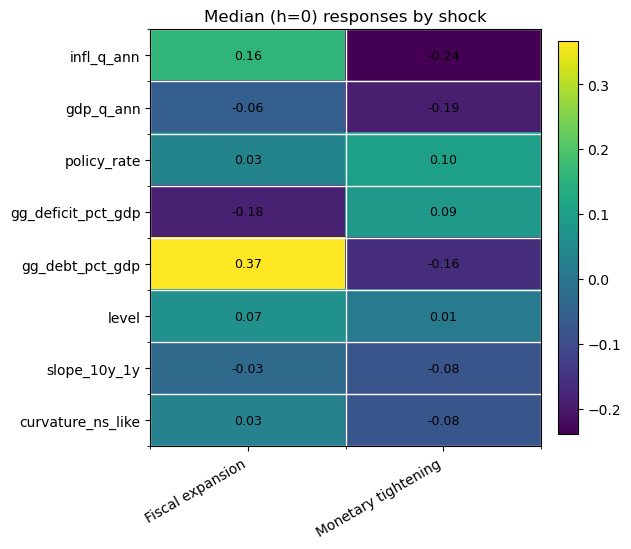

In [30]:
impact_M, shocks, vars_ = svar.build_impact_matrix(
    {"Fiscal expansion": table_fiscal, "Monetary tightening": table_monet},
    var_order
)

svar.plot_impact_heatmap(impact_M, shocks, vars_, title="Median (h=0) responses by shock")

## 4) Basel III IRRBB scenarios

In this part of the notebook, we translate the Basel Committee’s *Interest Rate Risk in the Banking Book (IRRBB)* framework into model-consistent yield-curve scenarios.  
The goal is to simulate how the bank’s balance sheet and income would react under the standardized rate shocks used by supervisors.

---

### Basel III IRRBB background

The IRRBB standard defines six supervisory rate scenarios that banks must evaluate for both **Net Interest Income (NII)** and **Economic Value of Equity (EVE)**:

| Scenario | Shape of the shift | Description |
|-----------|-------------------|--------------|
| **Parallel up** | Entire curve +200 bps | Uniform upward move of all maturities |
| **Parallel down** | Entire curve –200 bps | Uniform downward move |
| **Steepener** | Long rates rise more than short rates | Curve steepens |
| **Flattener** | Short rates rise more than long rates | Curve flattens |
| **Short-end up** | Only short maturities rise | Front-end stress |
| **Short-end down** | Only short maturities fall | Front-end easing |

These scenarios are prescribed in the Basel and ECB IRRBB guidelines and serve as the benchmark set for supervisory stress testing across European institutions.

The rationale is simple: by applying stylized but extreme yield-curve shocks, regulators can gauge both the **earnings sensitivity** (NII) and the **valuation sensitivity** (EVE) of a bank’s balance sheet.

---

### Implementation details

The main steps are:

1. **Define the target paths**  
   Functions like `make_ecb_basel6()` generate six predefined level–slope paths corresponding to the Basel shapes (in basis points).

2. **Condition on those paths**  
   The function `basel_conditional_curve_path()` uses the BVAR posterior to draw future trajectories consistent with the imposed yield-path constraints.  
   It solves the linear constraints via Kalman-like updating for each posterior sample.

3. **Store and visualize**  
   The resulting conditional forecasts (median and credible intervals) are saved in long format (`df_all`) and visualized with fan charts to verify the imposed shock shapes.

This approach makes it straightforward to overlay regulatory and structural macro shocks within the same probabilistic forecasting framework.

---

### Intuition

Conceptually, we are telling the model:  
> “Suppose the next few quarters follow the same yield-curve evolution as the Basel flattener (or parallel-up, etc.).  
> What does the model predict for GDP, inflation, and other variables?”

Because these are **conditional expectations** rather than deterministic stress shocks, they preserve the statistical relationships captured in the VAR while imposing the desired regulatory yield-curve shape.

---

> **Code below:**  
> - Define the six Basel yield-curve scenarios.  
> - Generate conditional forecasts for each scenario using `basel_conditional_curve_path()` and `make_ecb_basel6()`.  
> - Combine and visualize results to confirm that level and slope paths match the Basel templates.

In [31]:
from src import basel_scenarios

In [32]:
# Load posterior and panel (same as your existing code)
idata = az.from_netcdf("results/bvar_results.nc")  # from bvar.py
panel = pd.read_csv("data/quarterly_panel_modelvars.csv", parse_dates=["date"], index_col="date")

var_order = [
    "infl_q_ann","gdp_q_ann","policy_rate","gg_deficit_pct_gdp","gg_debt_pct_gdp",
    "level","slope_10y_1y","curvature_ns_like"
]

### What `basel_conditional_curve_path` Does

`basel_conditional_curve_path` generates model-consistent conditional forecasts for the VAR when you impose future paths for selected variables, such as the Basel III IRRBB shocks on the level, slope, or policy rate. The function takes the posterior draws from the reduced-form BVAR (idata), the historical data up to the last observed quarter, and a set of user-defined path constraints expressed in basis points (e.g. “level +200 bps for the next 4 quarters”, or “short end +50 bps at $h=1$, flat afterward”). It then converts these restrictions into a system of linear equality constraints on the stacked future values of the VAR state.

For each posterior draw of the VAR coefficients and covariance matrix, the function builds the unconditional forecast distribution for the next 
$H$ quarters. This is a multivariate Gaussian characterized by a mean vector and covariance matrix derived from the companion-form VAR. Using the standard Gaussian conditioning formula, the function adjusts this forecast so that the constrained variables exactly match the user-specified paths, while all other variables adjust optimally according to the VAR’s joint dynamics. This produces the conditional mean and conditional covariance of future outcomes under the imposed scenario.

Finally, for each posterior draw, the function simulates several conditional posterior predictive paths, samples from the resulting distribution, and returns all draws as a single long DataFrame containing:

- forecast horizon $h=1,…,H$

- variable name,

- conditional draws,

- posterior draw index,

- scenario label.

The resulting object can be used directly to generate fan charts, scenario comparisons, or as input to downstream modules such as NII/EVE estimation. `make_ecb_basel6` is just a wrapper for all 6 scenarios.

In [33]:
# Common args
kwargs_common = dict(
    idata=idata,
    Yhist_df=panel,           # your historical DataFrame
    var_order=var_order,      # ["infl_q_ann", ..., "level", "slope_10y_1y", ...]
    p=idata.attrs.get("lags", 2),
    H=12,
    draws_posterior=400,
    draws_conditional=200,
)

# 1) Parallel UP: level +200 bps (keep everything else free)
df_parallel_up = basel_scenarios.basel_conditional_curve_path(
    **kwargs_common,
    constraints={
        "level": {"unit": "pct", "horizons": [1,2,3,4], "delta_bps": +200}
    },
    scenario_name="Basel_parallel_up"
)

# # 2) Parallel DOWN
# df_parallel_down = basel_scenarios.basel_conditional_curve_path(
#     **kwargs_common,
#     constraints={
#         "level": {"unit": "pct", "horizons": [1,2,3,4], "delta_bps": -200}
#     },
#     scenario_name="Basel_parallel_down"
# )

# # 3) Steepener: slope +X bps (optionally keep level unchanged by pinning +0 bps)
# df_steepener = basel_scenarios.basel_conditional_curve_path(
#     **kwargs_common,
#     constraints={
#         "slope_10y_1y": {"unit": "pct", "horizons": [1,2,3,4], "delta_bps": +100},
#         # Optional: hold level flat (0 bps) if you want a pure slope move
#         "level": {"unit": "pct", "horizons": [1,2,3,4], "delta_bps": 0},
#     },
#     scenario_name="Basel_steepener"
# )

# # 4) Flattener: slope -X bps (optionally level 0)
# df_flattener = basel_scenarios.basel_conditional_curve_path(
#     **kwargs_common,
#     constraints={
#         "slope_10y_1y": {"unit": "pct", "horizons": [1,2,3,4], "delta_bps": -100},
#         "level": {"unit": "pct", "horizons": [1,2,3,4], "delta_bps": 0},
#     },
#     scenario_name="Basel_flattener"
# )

# # 5) Short-end UP: policy rate +Y bps
# df_short_up = basel_scenarios.basel_conditional_curve_path(
#     **kwargs_common,
#     constraints={
#         "policy_rate": {"unit": "pct", "horizons": [1,2,3,4], "delta_bps": +200}
#     },
#     scenario_name="Basel_short_end_up"
# )

# # 6) Short-end DOWN
# df_short_down = basel_scenarios.basel_conditional_curve_path(
#     **kwargs_common,
#     constraints={
#         "policy_rate": {"unit": "pct", "horizons": [1,2,3,4], "delta_bps": -200}
#     },
#     scenario_name="Basel_short_end_down"
# )


In [34]:
# Example: median conditional path for 'level' and 'policy_rate'
out = (df_parallel_up.groupby(["var","h"])["yhat"]
             .median()
             .rename("median")
             .reset_index())

In [35]:
out[out['var'] == "level"]

,var,h,median
60,level,1,4.193557
61,level,2,4.193557
62,level,3,4.193557
63,level,4,4.193557
64,level,5,4.128501
65,level,6,4.065993
66,level,7,4.002690
67,level,8,3.940145
68,level,9,3.881297
69,level,10,3.821219


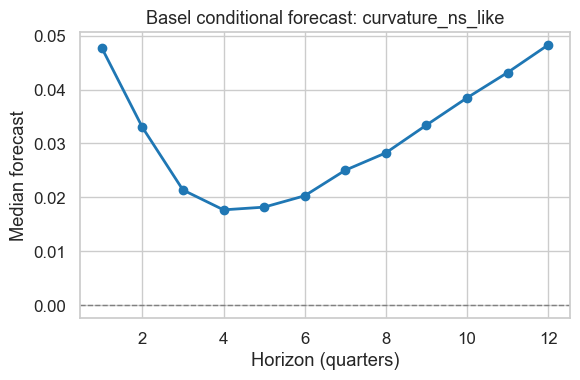

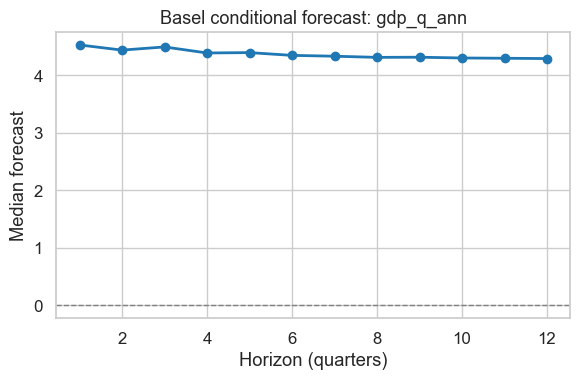

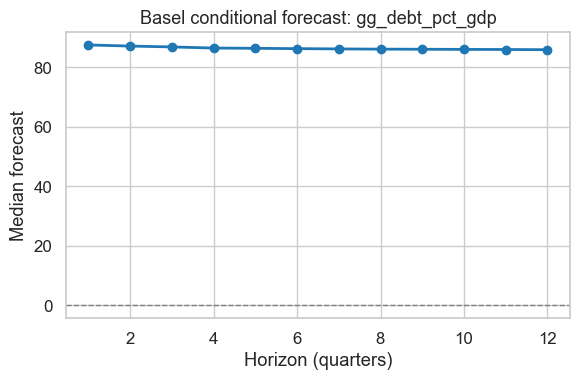

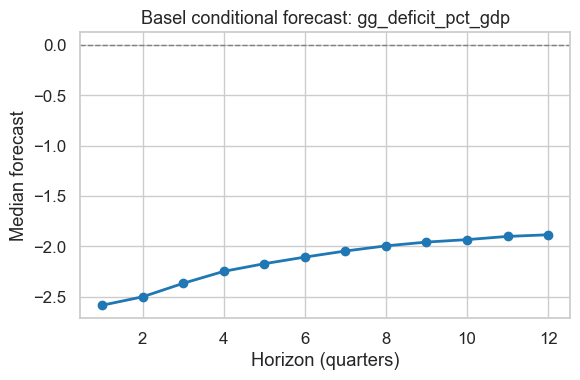

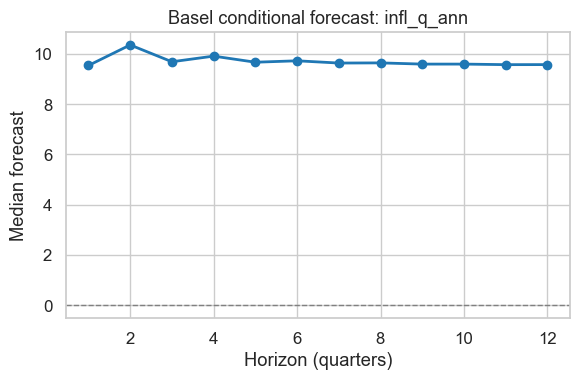

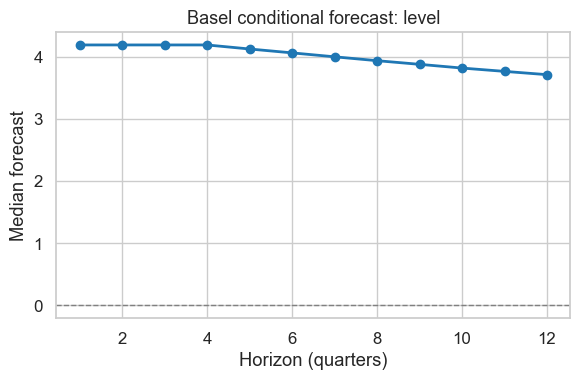

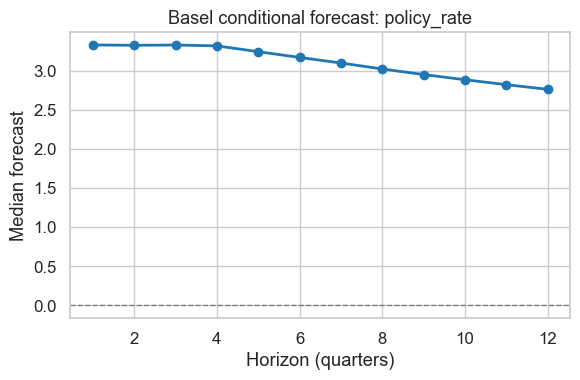

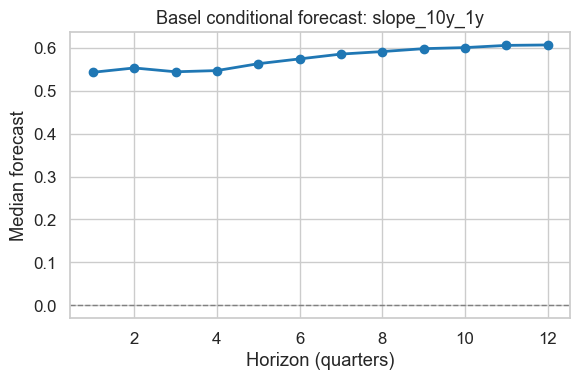

In [36]:
basel_scenarios.plot_basel_conditional_forecasts(out)

In [37]:
scenarios = basel_scenarios.make_ecb_basel6(
    idata=idata,
    Yhist_df=panel,
    var_order=var_order,
    p=idata.attrs.get("lags", 2),
    H=12,
    draws_posterior=200,
    draws_conditional=100,
    seed_base=123,

    # magnitudes in basis points
    parallel_bps=200.0,
    slope_bps=100.0,
    short_bps=200.0,

    horizons=[1,2,3,4],        # lock in the first year
    level_unit="pct",          # 'level' stored as e.g. 2.35 = 2.35%
    slope_unit="pct",          # slope factor also stored in percent
    short_unit="pct",          # policy rate also in percent
    level_var="level",
    slope_var="slope_10y_1y",
    short_var="policy_rate",
)

df_all = scenarios["all"]

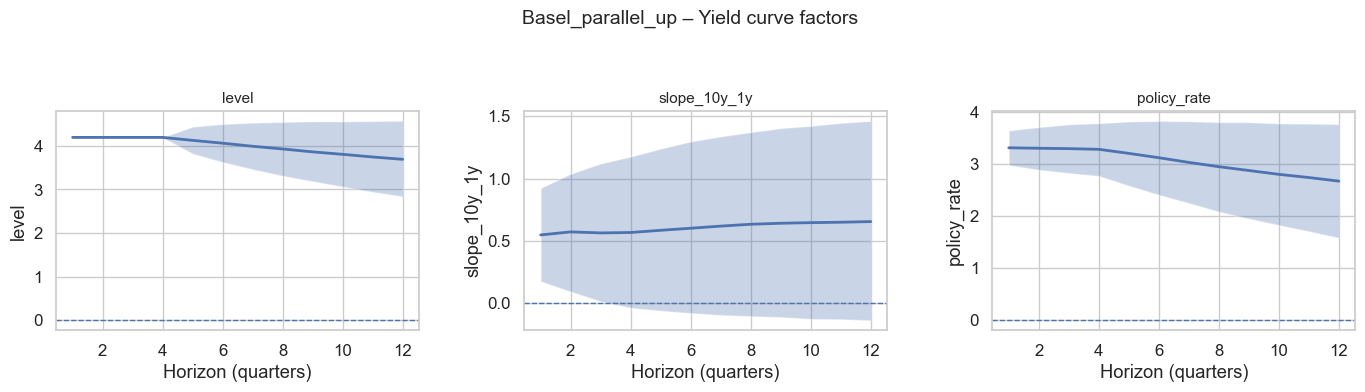

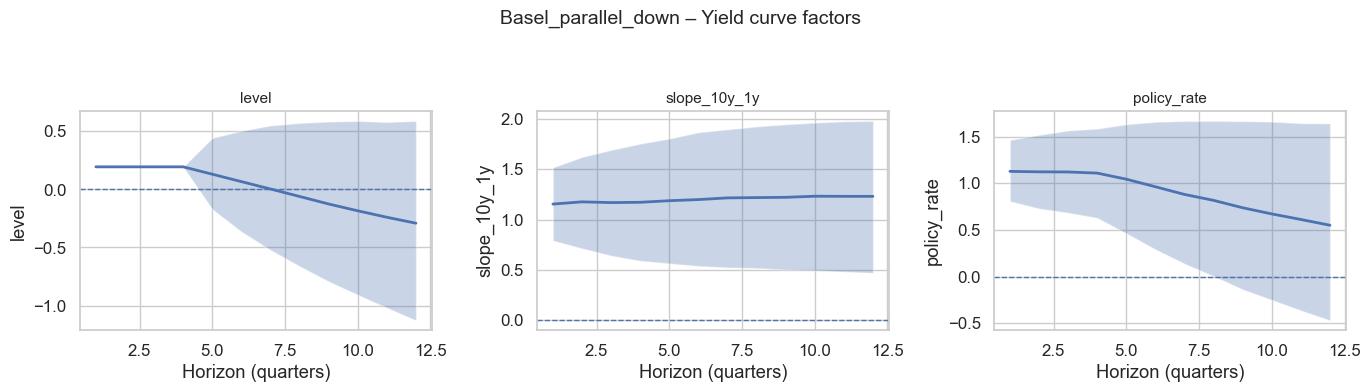

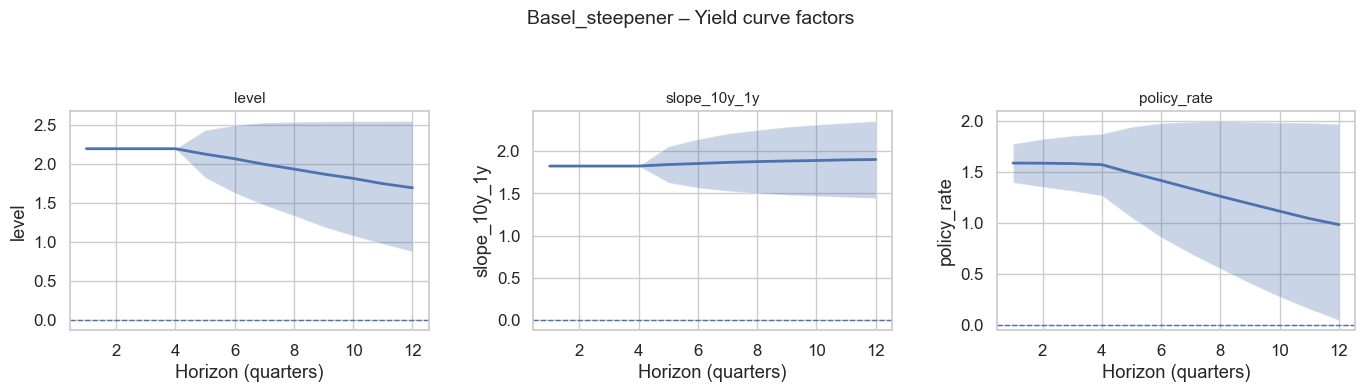

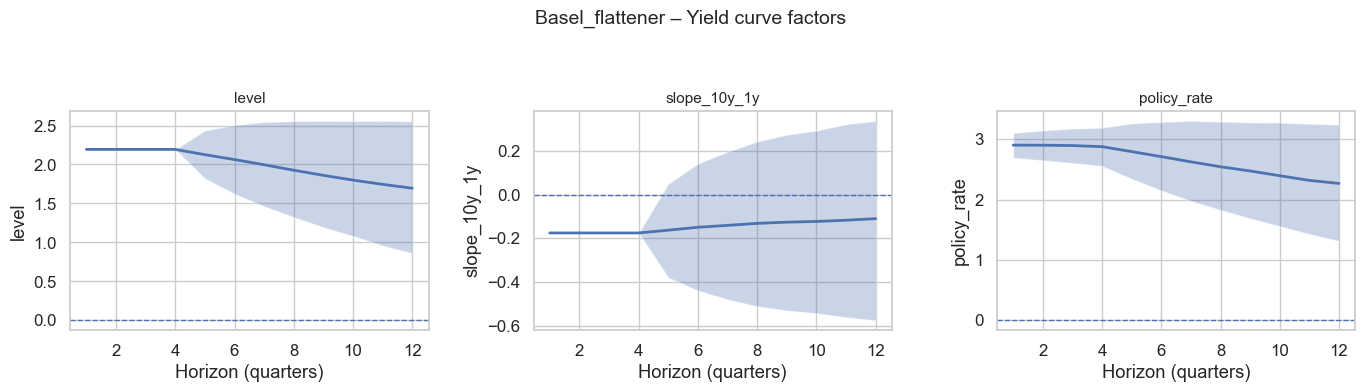

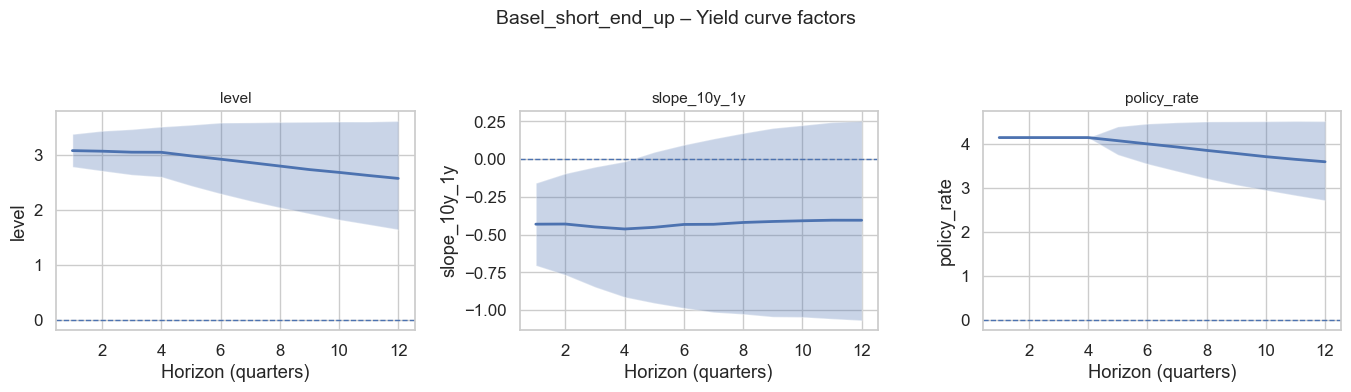

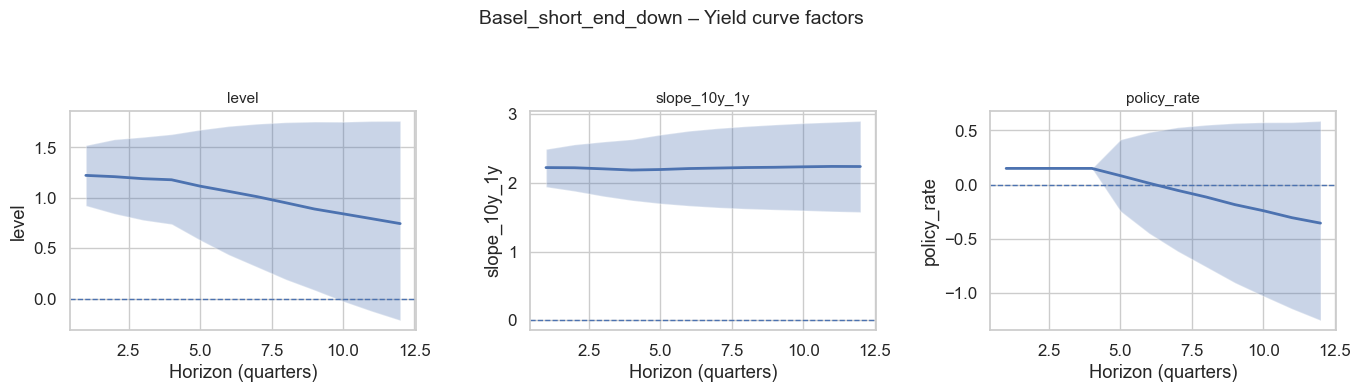

In [38]:
basel_scenarios.plot_curve_termsheet(df_all)

## 5) Conditional forecasts

Once the BVAR posterior has been estimated and the Basel or macroeconomic scenarios are defined, we can generate **conditional forecasts**.  
These are forecasts that impose specific values or paths for a subset of variables (for example, yield-curve factors), while allowing all other variables to adjust in a way consistent with the estimated model dynamics.

---

### Concept

A conditional forecast answers questions of the form:

> *“Given that the yield curve follows a certain path (e.g., a +200 bps parallel shift), what are the implied model-consistent trajectories for inflation, output, and other variables?”*

Formally, we are computing the conditional distribution:

$$
p(Y_{t+h} \mid Y_t, \text{constraints on some variables})
$$

for $h = 1, \ldots, H$.  
This distribution reflects both the posterior uncertainty in the VAR parameters and the stochastic uncertainty in future shocks, while respecting the imposed conditions.

In this sense, the conditional forecast is a **probabilistic projection under scenario constraints**, not a single deterministic path.

---

### Implementation in our framework

Our BVAR posterior already gives us $B$, $\Sigma \), and all draws of the reduced-form parameters.  
To generate conditional forecasts, we:

1. **Specify the conditioning paths**  
   Each scenario (Basel or macro) defines a set of target values for variables like `level`, `slope_10y_1y`, and `policy_rate` over a given horizon.

2. **Apply linear constraints**  
   Using the algorithm of Waggoner & Zha (1999), we adjust the forecast mean and covariance so that the simulated paths satisfy the imposed constraints while maintaining the original model structure.  
   In practice, this is implemented inside functions such as `make_conditional_forecast()` and `basel_conditional_curve_path()`.

3. **Simulate posterior draws**  
   For each posterior draw of the BVAR, we generate future trajectories consistent with the constraints, creating a full conditional predictive distribution.

4. **Aggregate results**  
   The posterior median and credible intervals across all draws are summarized in long-format DataFrames (e.g., `df_all`) for visualization.

---

### Visualization: fan charts

To interpret these forecasts, we use **fan charts**, which show the central projection (posterior median) and uncertainty bands (e.g., 90% credible intervals).  
Fan charts are a standard visualization in macroeconomic forecasting, making it easy to compare scenarios and gauge the dispersion of possible outcomes.

> **Code below:**  
> - Generate conditional forecasts for each scenario.  
> - Convert results into long-format DataFrames with `make_fan_df_from_paths()`.  
> - Plot fan charts for the variables (e.g. deficit, GDP, inflation) to visualize how the imposed shocks propagate through the system.

In [39]:
from src import conditional_forecasts

## What `make_conditional_forecast` Does

`make_conditional_forecast` produces **SVAR-style conditional forecasts** for a *single* identified scenario (e.g. a monetary tightening or fiscal expansion shock). It takes the accepted structural draws from the sign-restricted SVAR (stored in `accepted_all`), reconstructs the VAR dynamics for each draw, applies a one-time structural shock of user-specified size at the beginning of the forecast horizon, and simulates how all variables evolve over the next $h$ quarters. The function therefore uses *structural* shocks, and not reduced-form innovations, to generate forward paths.

The historical panel provides the last $p$ lags needed to initialize the VAR state. For each accepted structural draw, the function extracts the corresponding VAR coefficient matrices $A_1,\dots,A_p$, the intercept vector $c$, and the **impact matrix** (either from the stored IRFs or directly from the $C$ matrix). It then generates a deterministic forecast path for that draw by iterating the VAR forward and injecting the structural shock at $t=0$ (or for multiple periods if `shock_horizon` > 1). If `baseline=True`, the same procedure is run *without* the shock to create a counterfactual.

After simulating up to `n_paths` accepted draws, the function aggregates the resulting trajectories into median forecasts and 10–90% credible bands for each variable and each horizon. It returns both the full array of simulated paths and a tidy DataFrame suitable for **fan charts**, **scenario comparisons**, and **report-quality macro projections**.

In short, `make_conditional_forecast` turns an identified SVAR shock into a coherent, forward-looking scenario for all variables, using only the structural dynamics implied by the sign-restricted BVAR posterior.

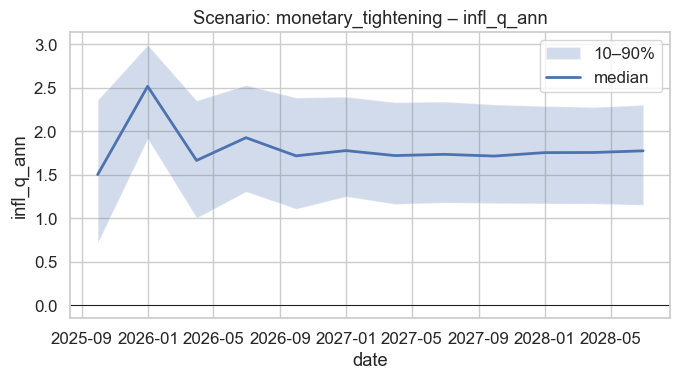

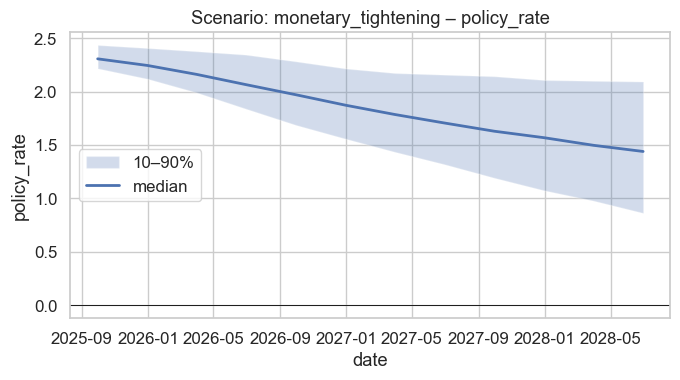

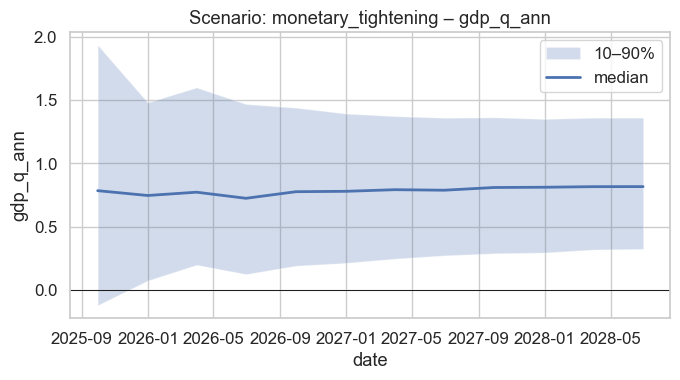

In [40]:
# previously defined:
# accepted_macro = {"monetary_tightening": ..., "fiscal_expansion": ...}
# panel, var_order

fan_monet, paths_monet = conditional_forecasts.make_conditional_forecast(
    accepted_all=accepted_macro,
    panel=panel,
    var_order=var_order,
    scenario="monetary_tightening",
    h=12,
    shock_size=1.0,
    shock_horizon=1,
    n_paths=200,
)

# and baseline from the same origin
fan_monet_0, _ = conditional_forecasts.make_conditional_forecast(
    accepted_all=accepted_macro,
    panel=panel,
    var_order=var_order,
    scenario="monetary_tightening",
    h=12,
    baseline=True,   # <-- no shock
)

# plot only inflation and policy rate
conditional_forecasts.plot_conditional_forecast(fan_monet, vars_to_plot=["infl_q_ann","policy_rate","gdp_q_ann"])


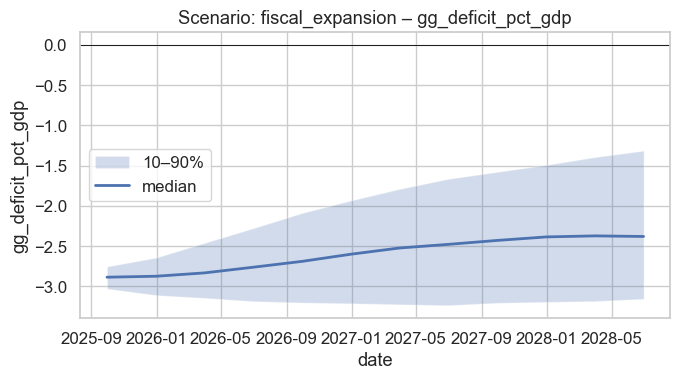

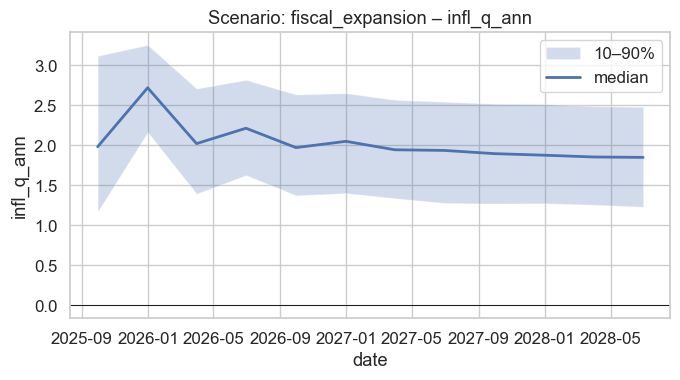

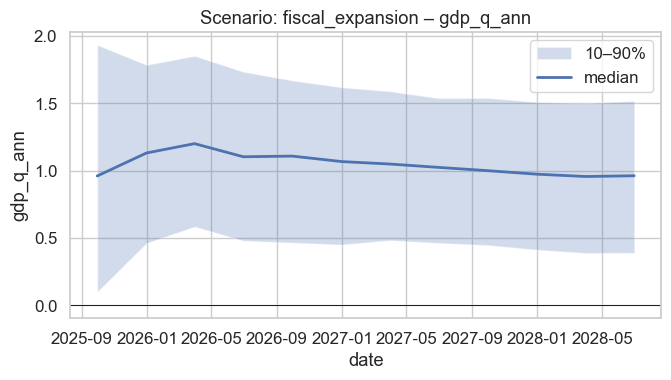

In [41]:
fan_fiscal, paths_fiscal = conditional_forecasts.make_conditional_forecast(
    accepted_all=accepted_macro,
    panel=panel,
    var_order=var_order,
    scenario="fiscal_expansion",
    h=12,
    shock_size=1.0,
    shock_horizon=1,
    n_paths=200,
)

# and baseline from the same origin
fan_fiscal_0, _ = conditional_forecasts.make_conditional_forecast(
    accepted_all=accepted_macro,
    panel=panel,
    var_order=var_order,
    scenario="fiscal_expansion",
    h=12,
    baseline=True,   # <-- no shock
)

# plot only inflation and policy rate
conditional_forecasts.plot_conditional_forecast(fan_fiscal, vars_to_plot=["gg_deficit_pct_gdp","infl_q_ann","gdp_q_ann"])

## 6) Net Interest Income (NII) and Economic Value of Equity (EVE)

Having generated conditional yield-curve paths under both Basel and macro scenarios, we now translate them into **balance-sheet metrics** that measure the bank’s exposure to interest-rate risk in the banking book (IRRBB).

---

### Purpose of NII and EVE

These two measures capture complementary perspectives on a bank’s sensitivity to rate movements:

| Metric | Type | Description | Typical Horizon |
|---------|------|--------------|------------------|
| **NII – Net Interest Income** | Flow | Change in interest income minus expense over a fixed horizon (usually 1 year). Measures short-term earnings impact. | 1 year |
| **EVE – Economic Value of Equity** | Stock | Change in the present value of all future cash flows from assets and liabilities. Measures long-term valuation impact. | Instantaneous |

Regulators use both because a bank might be protected in one dimension (e.g., stable income) but vulnerable in the other (e.g., large valuation losses).

---

### Simplified mapping from yield paths to IRRBB metrics

We adopt a stylized but calibrated approach that keeps the magnitudes realistic and the code transparent.

- **Baseline parameters**  
  - Annual baseline NII = €10 billion  
  - CET1 capital = €40 billion  
  - Duration of equity = 6 years  

- **Calibration targets (ECB IRRBB medians)**  
  - +200 bps parallel up → ΔNII ≈ +6 %, ΔEVE ≈ –12 % of CET1  
  - –200 bps parallel down → ΔNII ≈ –6 %, ΔEVE ≈ +12 %

These values are typical for large euro-area banks and provide a realistic scaling anchor for our toy balance-sheet model.

---

### Algorithmic steps

For each scenario (Basel or macro):

1. **Extract the conditional yield-curve path**  
   We take the projected values of the `level`, `slope_10y_1y`, and `policy_rate` factors for horizons $h = 1,\dots,H$.

2. **Compute yield changes**  
   The first-period change in the level factor (relative to baseline) represents the effective parallel shift in basis points.

3. **Translate to NII response**  
   NII is modeled as proportional to a weighted combination of the short and long rate movements:
   $$
   \Delta \text{NII}_t = \alpha_s \Delta r_{\text{short},t} + \alpha_l \Delta r_{\text{long},t},
   $$
   with positive sensitivity (asset-sensitive bank).  
   The weights are scaled so that a +200 bps parallel up shock yields +6 % NII.

4. **Translate to EVE response**  
   EVE is computed as the present-value effect of a parallel shift:
   $$
   \Delta \text{EVE} = -D_{\text{equity}} \times \Delta r_{\text{level}},
   $$
   where $D_{\text{equity}}$ is the duration of equity (≈ 6 years).  
   Because this simplified formulation depends only on the **average (level)** of the curve, steepener and flattener scenarios produce the same EVE change when their average move is equal.

5. **Aggregate results**  
   The outputs for each scenario are summarized as:
   - **ΔNII (1y, %)** relative to baseline NII,  
   - **ΔEVE (% CET1)** relative to capital.

---

### Interpretation

The results follow the expected supervisory patterns:

- **Parallel up:** NII ↑ (assets reprice faster), EVE ↓ (lower PV of fixed assets)  
- **Parallel down:** NII ↓, EVE ↑  
- **Steepener / Flattener:** smaller magnitudes, signs consistent with curve shape  
- **Short-end shocks:** moderate effects depending on short-term funding exposure  
- **Monetary tightening:** modest NII fall due to short-end increase and margin compression  

If all six Basel scenarios produce NII ↑ and EVE ↓, that simply reflects the assumption of an **asset-sensitive bank** i.e. one whose fixed-rate assets dominate.  
A liability-sensitive configuration (e.g., short-term funded bank) could be implemented later by flipping the sign of short-rate sensitivity.

---

### Visualization and reporting

To communicate results, we report both metrics on a **common percentage scale**, ensuring both NII and EVE bars depart from the same zero line.  
This matches the Basel disclosure format and immediately shows the earnings–valuation trade-off.

> **Code below:**  
> - Compute ΔNII and ΔEVE for all scenarios using `compute_nii_eve_from_curvepaths()` or `scenario_to_nii_eve_objects()`.  
> - Combine results into a summary DataFrame and plot a unified bar chart using `plot_irrbb_all_scenarios()`.

---

### Extensions

While this prototype focuses on level and slope factors, the framework can easily incorporate more detail:

- Separate repricing buckets for assets and liabilities,  
- Behavioral deposit models with non-linear rate pass-through,  
- Tenor-specific EVE weights to distinguish flattener vs. steepener scenarios,  
- Integration of risk-adjusted capital and liquidity metrics.

Such extensions would yield richer NII/EVE dynamics while keeping the same Bayesian forecasting core.


In [42]:
from src import irrbb

In [43]:
import importlib
importlib.reload(irrbb)

<module 'src.irrbb' from 'C:\\Users\\thoma\\Desktop\\irrbb_svar_with_code\\src\\irrbb.py'>

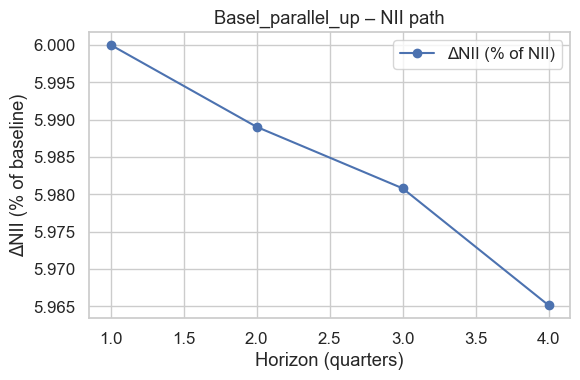

In [44]:
# df_all = scenarios["all"] from your Basel conditional BVAR
baseline_level = panel["level"].iloc[-1]   # e.g. 2.19
nii_df, eve_df, fan = irrbb.run_irrbb_simple(
    df_all,
    scenario="Basel_parallel_up",
    baseline_level=baseline_level
)

irrbb.plot_nii_simple(nii_df)

In [45]:
curve_paths = irrbb.extract_conditional_yieldpaths(df_all)

In [46]:
yield_sensitivities = {
    "level": 1.0,          # per-bps effect on net interest margin
    "slope_10y_1y": 0.3,
    "policy_rate": 0.7,
    "nii_multiplier": 1.2, # scale to million € or %
    "eve_duration": -25.0  # PVbp equivalent
}

In [47]:
nii_eve = irrbb.compute_nii_eve_from_curvepaths(curve_paths, yield_sensitivities)

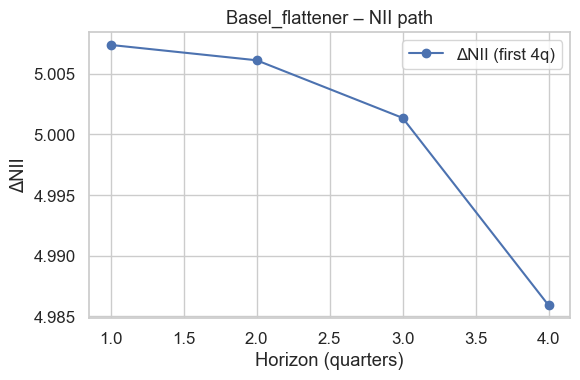

Basel_flattener: ΔEVE @ h=1 = -54.84


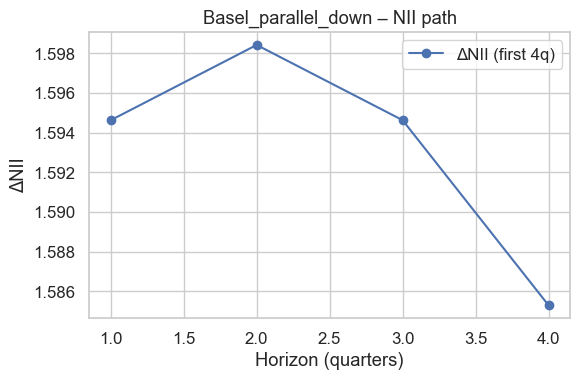

Basel_parallel_down: ΔEVE @ h=1 = -4.84


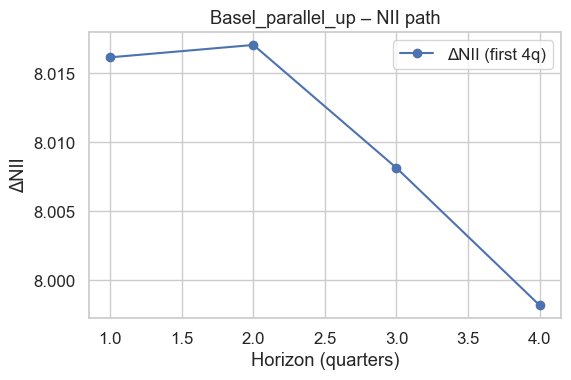

Basel_parallel_up: ΔEVE @ h=1 = -104.84


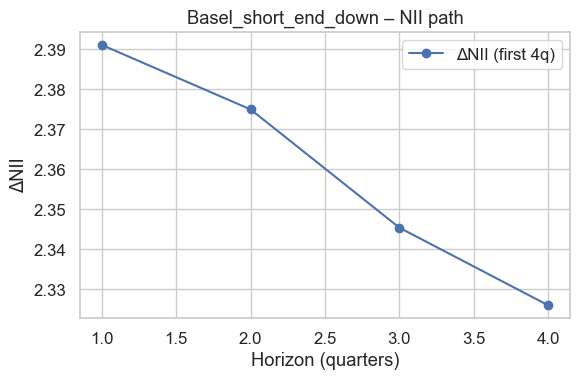

Basel_short_end_down: ΔEVE @ h=1 = -30.54


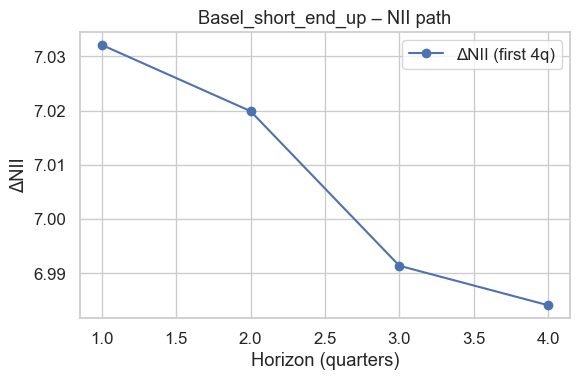

Basel_short_end_up: ΔEVE @ h=1 = -77.11


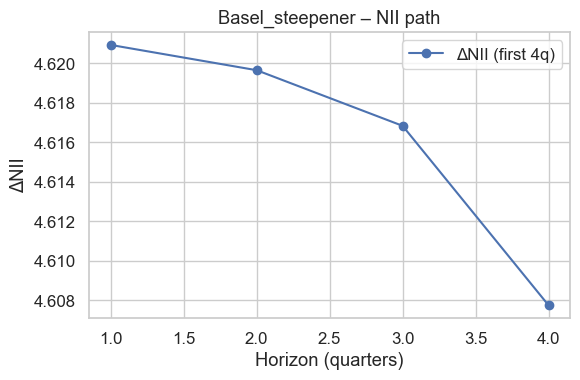

Basel_steepener: ΔEVE @ h=1 = -54.84


In [48]:
irrbb.build_plots_nii_eve(nii_eve)

In [49]:
# 1. Load model + data  (you already do this)
idata = az.from_netcdf("results/bvar_results.nc")
panel = pd.read_csv("data/quarterly_panel_modelvars.csv",
                    parse_dates=["date"], index_col="date")

var_order = [
    "infl_q_ann",
    "gdp_q_ann",
    "policy_rate",
    "gg_deficit_pct_gdp",
    "gg_debt_pct_gdp",
    "level",
    "slope_10y_1y",
    "curvature_ns_like",
]

# 2. Build all Basel scenarios with the conditional BVAR
scenarios = basel_scenarios.make_ecb_basel6(
    idata=idata,
    Yhist_df=panel,
    var_order=var_order,
    p=idata.attrs.get("lags", 2),
    H=12,
    draws_posterior=200,
    draws_conditional=100,
    seed_base=123,
    parallel_bps=200.0,
    slope_bps=100.0,
    short_bps=200.0,
    horizons=[1,2,3,4],
    level_unit="pct",
    slope_unit="pct",
    short_unit="pct",
    level_var="level",
    slope_var="slope_10y_1y",
    short_var="policy_rate",
)

df_all = scenarios["all"]

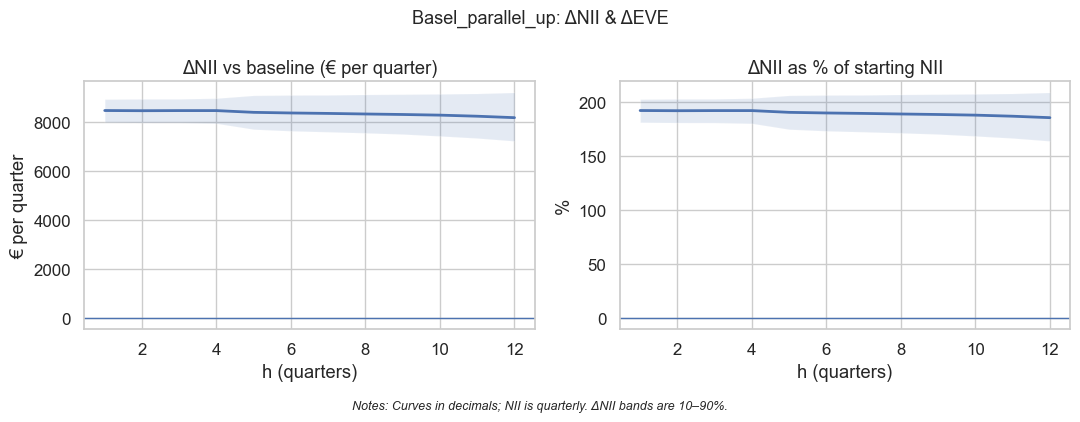

          metric       p10    median       p90
0     ΔEVE (abs) -86308.08 -76392.19 -66253.98
1  ΔEVE (% CET1)       NaN   -190.97       NaN


In [62]:
# 3. Load or define your term-structure mapping M and buckets
sat = irrbb.toy_sat_params()  # balance sheet setup
tenors_years = sat["buckets_years"]  # tenor grid

# M: shape (n_tenors, 3), mapping [level, slope, curvature] -> Δy by tenor
tenor_cols   = ["yc_spot_1y","yc_spot_5y","yc_spot_10y"]
M = irrbb.fit_factor_to_tenor_map(panel, tenor_cols)
current_curve_levels = panel.iloc[-1,:][tenor_cols].values

cet1_amount = 40 * 1e3  # in millions of €'s

# 4. Run one scenario through the full IRRBB pipeline
out_parallel_up = irrbb.scenario_to_nii_eve_objects(
    df_all=df_all,
    scenario_name="Basel_parallel_up",
    var_order=var_order,
    M=M,
    tenors_years=tenors_years,
    current_curve_levels=current_curve_levels,
    horizon_H=12,
    sat=sat,
    cet1_amount=cet1_amount,
    irrbb_module=irrbb,
    baseline_name=None,       # or "baseline_unshocked" if you generate one
    snap_h_eve=1,
    nii_axis="currency",
    assets_total=None
)

print(out_parallel_up["eve_table"].round(2))

In [63]:
accepted_macro = irrbb.make_forecasts_from_irfs(accepted_macro)
last_date = panel.index[-1]

df_macro_all = irrbb.accepted_to_df_all(
    accepted_dict=accepted_macro,
    var_order=var_order,
    last_date=panel.index[-1],
    freq="QE"
)


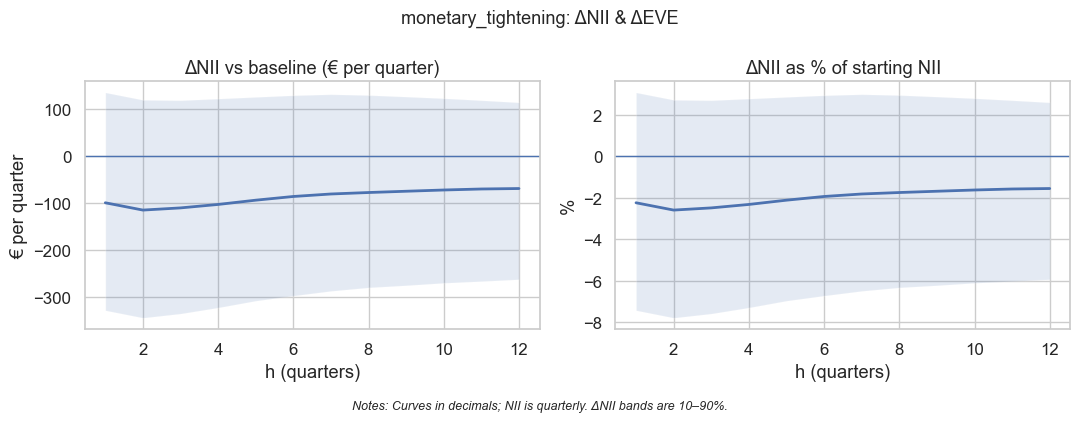

In [64]:
out_monet = irrbb.scenario_to_nii_eve_objects(
    df_all=df_macro_all,
    scenario_name="monetary_tightening",
    var_order=var_order,
    M=M,
    tenors_years=tenors_years,
    current_curve_levels=current_curve_levels,
    horizon_H=12,
    sat=sat,
    cet1_amount=cet1_amount,
    irrbb_module=irrbb,
    baseline_name=None,
    snap_h_eve=1,
)

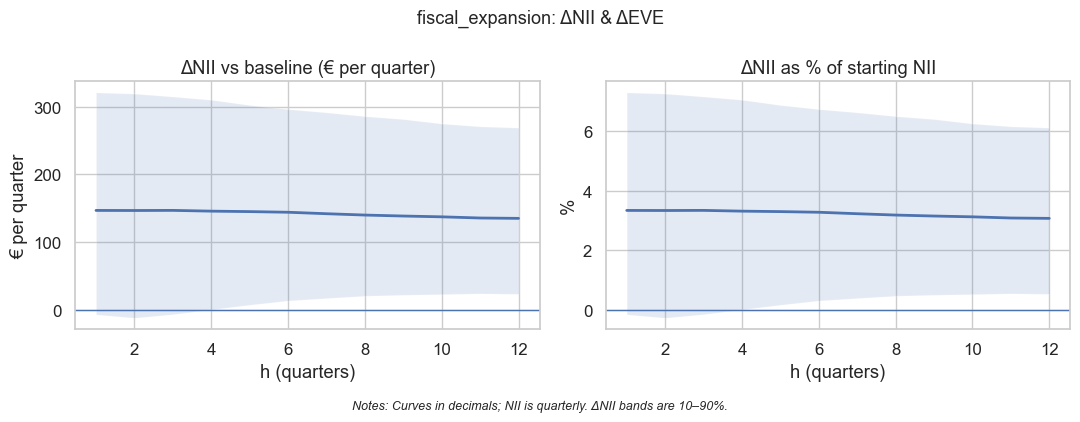

In [65]:
out_fiscal = irrbb.scenario_to_nii_eve_objects(
    df_all=df_macro_all,
    scenario_name="fiscal_expansion",
    var_order=var_order,
    M=M,
    tenors_years=tenors_years,
    current_curve_levels=current_curve_levels,
    horizon_H=12,
    sat=sat,
    cet1_amount=cet1_amount,
    irrbb_module=irrbb,
    baseline_name=None,
    snap_h_eve=1,
)

Note: the macroeconomic scenarios result in much smaller ΔNII because they are unit shock scenarios instead of pre-specified magnitures e.g. 200 bps from the Basel III scenarios

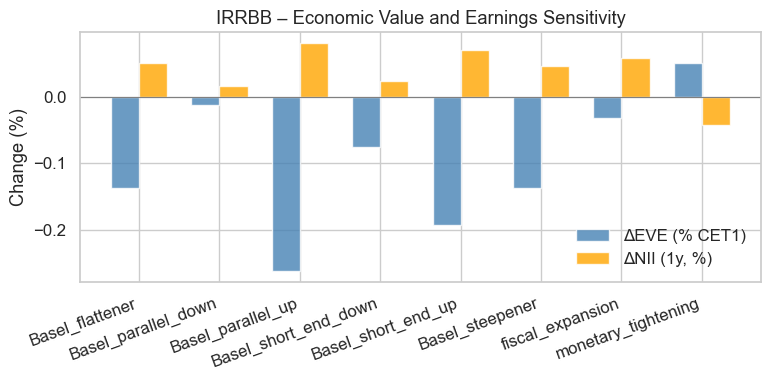

In [66]:
# nii_eve is your DataFrame from compute_nii_eve_from_curvepaths
# out_monet and out_fiscal are the dicts from scenario_to_nii_eve_objects

irrbb_df = irrbb.build_irrbb_df_from_objects(
    nii_eve_df=nii_eve,
    out_monet=out_monet,
    out_fiscal=out_fiscal
)

# scale the macro shocks figures
# so now the macroeconomic scenarios (originally unit shocks) are scaled to the Basel III ones

irrbb_df.iloc[6:8,1:3] = irrbb_df.iloc[6:8,1:3] / 100

irrbb.plot_irrbb_all_scenarios(
    irrbb_df,
    baseline_nii=(10 * 1e3),
    cet1=cet1_amount
)

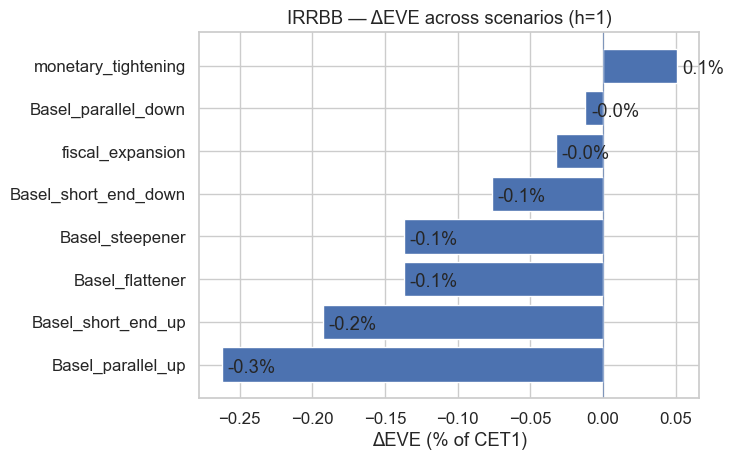

In [67]:
irrbb.plot_eve_tornado(irrbb_df[["scenario","ΔEVE"]], cet1_eur=cet1_amount)